### Libreries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import json
import requests
import folium
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import importlib
import pickle

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# System
import sys, os
from pathlib import Path
# Add project path to sys to read custom modules, JN works from its own path
sys.path.append(os.path.abspath(".."))

# Utilities
from utils.viz_utils import *
from utils.custom_transformers import *
from utils.ml_utils import *

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

%config InlineBackend.figure_format = 'retina'

### Reading data with SQL

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = f'{BASE_DIR}/data'

customers = pd.read_csv(f'{DATA_PATH}/olist_customers_dataset.csv')
geolocation = pd.read_csv(f'{DATA_PATH}/olist_geolocation_dataset.csv')
order_items = pd.read_csv(f'{DATA_PATH}/olist_order_items_dataset.csv')
order_payments = pd.read_csv(f'{DATA_PATH}/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(f'{DATA_PATH}/olist_order_reviews_dataset.csv')
orders = pd.read_csv(f'{DATA_PATH}/olist_orders_dataset.csv')
products = pd.read_csv(f'{DATA_PATH}/olist_products_dataset.csv')
sellers = pd.read_csv(f'{DATA_PATH}/olist_sellers_dataset.csv')
category_translation = pd.read_csv(f'{DATA_PATH}/product_category_name_translation.csv')

### Summary of the data
We have several tables, each one describing a specific topic related to e-commerce sales. Let's take a look at each one.
We'll create a data frame with important information from each one, like number of rows, number of columns and null amount

In [3]:
# Collections for each dataset
datasets = [customers, geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers]
names = ['customers', 'geolocation', 'orders', 'order_items', 'order_payments',
         'order_reviews', 'products', 'sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['percent_null'] = [(df.isnull().sum().sum() / (orders.shape[0] * orders.shape[1])) for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info.style.background_gradient(cmap='viridis')

In [4]:
names1 = names.copy()
names1.remove('customers')


datasets1 = [geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers]

Let's delve into the features of each table. We investigate its data type, number of nulls, and categorical cardinality.

In [5]:
df_overview = data_overview(customers)
name_col = ['customers'] * customers.shape[1]

for name, df in zip(names1, datasets1):
    name_col += [name] * df.shape[1]
    df_overview = pd.concat([df_overview, data_overview(df)])
    df_overview['dataset_name'] = name_col
    
df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

dataset_name                        feature  qtd_null  percent_null  \
0       customers                    customer_id         0      0.000000   
1       customers             customer_unique_id         0      0.000000   
2       customers       customer_zip_code_prefix         0      0.000000   
3       customers                  customer_city         0      0.000000   
4       customers                 customer_state         0      0.000000   
0     geolocation    geolocation_zip_code_prefix         0      0.000000   
1     geolocation                geolocation_lat         0      0.000000   
2     geolocation                geolocation_lng         0      0.000000   
3     geolocation               geolocation_city         0      0.000000   
4     geolocation              geolocation_state         0      0.000000   
0          orders  order_delivered_customer_date      2965      0.029817   
1          orders   order_delivered_carrier_date      1783      0.017930   
2          orders              order_approved_at       160      0.001609   
3          orders                       order_id         0      0.000000   
4          orders       order_purchase_timestamp         0      0.000000   
5          orders                   order_status         0      0.000000   
6          orders                    customer_id         0      0.000000   
7          orders  order_estimated_delivery_date         0      0.000000   
0     order_items                       order_id         0      0.000000   
1     order_items                  order_item_id         0      0.000000   
2     order_items                     product_id         0      0.000000   
3     order_items                      seller_id         0      0.000000   
4     order_items            shipping_limit_date         0      0.000000   
5     order_items                          price         0      0.000000   
6     order_items                  freight_value         0      0.000000   
0  order_payments                       order_id         0      0.000000   
1  order_payments             payment_sequential         0      0.000000   
2  order_payments                   payment_type         0      0.000000   
3  order_payments           payment_installments         0      0.000000   
4  order_payments                  payment_value         0      0.000000   
0   order_reviews           review_comment_title     87656      0.883415   
1   order_reviews         review_comment_message     58247      0.587025   
2   order_reviews                      review_id         0      0.000000   
3   order_reviews                   review_score         0      0.000000   
4   order_reviews                       order_id         0      0.000000   
5   order_reviews           review_creation_date         0      0.000000   
6   order_reviews        review_answer_timestamp         0      0.000000   
0        products          product_category_name       610      0.018512   
1        products     product_description_lenght       610      0.018512   
2        products            product_name_lenght       610      0.018512   
3        products             product_photos_qty       610      0.018512   
4        products               product_weight_g         2      0.000061   
5        products              product_height_cm         2      0.000061   
6        products              product_length_cm         2      0.000061   
7        products               product_width_cm         2      0.000061   
8        products                     product_id         0      0.000000   
0         sellers                      seller_id         0      0.000000   
1         sellers         seller_zip_code_prefix         0      0.000000   
2         sellers                    seller_city         0      0.000000   
3         sellers                   seller_state         0      0.000000   

     dtype  qtd_cat  
0   object    99441  
1   object    96096  
2    int64        0  
3   object     4119  
4   object       2

Now we have enough information to know how to combine the different tables, and start doing the EDA.
# Exploratory Data Analysis
Now we will perform an exploratory data analysis to gain insights about e-commerce in Brazil. To make it more interesting, we will divide the analysis into different topics so we can explore the data in each table.

We know that E-commerse is a growing trend, but how exactly is it growing?
To observe the trend, we must extract some temporal information from the order_purchase_timestamp feature.

In [6]:

df_orders = orders.merge(customers, how='left', on='customer_id')


# Changing the dtype for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes (Year and Month)
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes (Day and Day of Week)
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes (Hour and Time of the Day)
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

With the data processed, we can now perform a complete analysis of the number of orders placed during the dataset period. Let's plot three graphs that answer the following questions:
1. Is there a growing trend in Brazilian e-commerce?
2. On what day of the week do people tend to shop the most?
3. At what time of day do they usually shop (dawn, morning, afternoon, or night)?

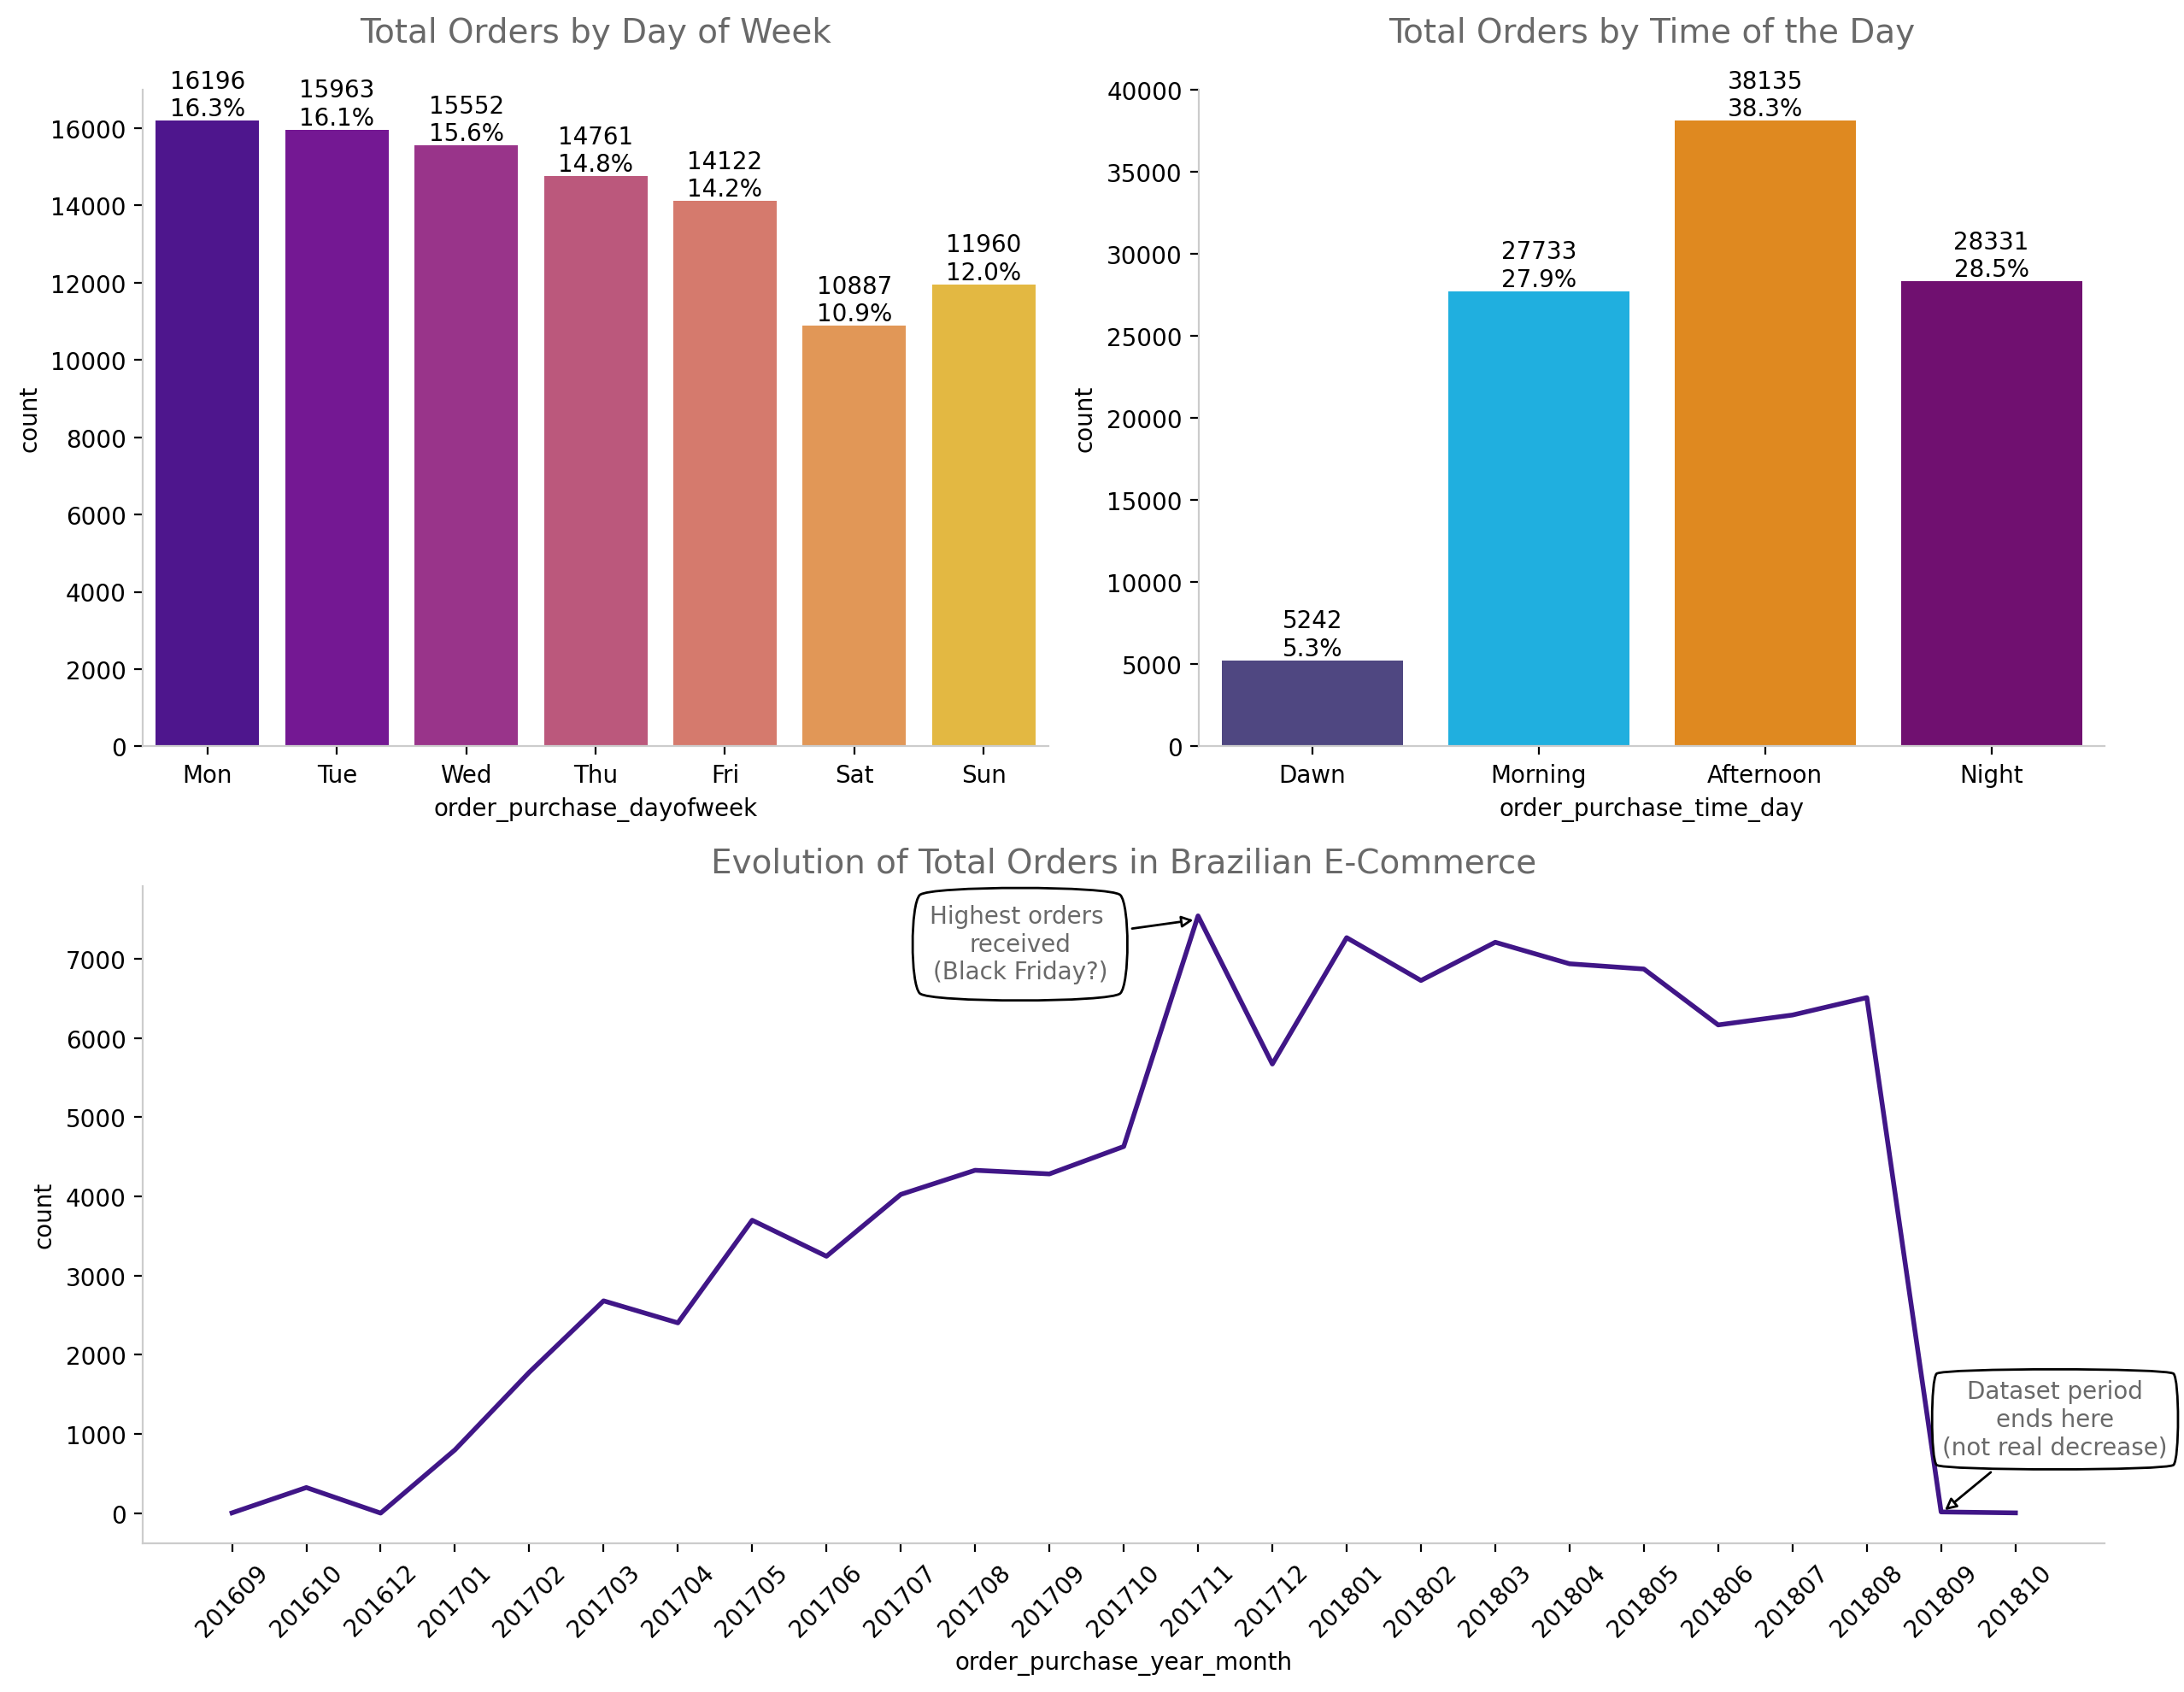

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# GridSpect
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

# Evolution of e-commerce orders along time | Lineplot
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='#401687', linewidth=2)
ax1.annotate(f'Highest orders \nreceived\n(Black Friday?)', xy=(13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Dataset period\nends here\n(not real decrease)', xy=(23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Total of orders by day of week | Barchart
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='plasma')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)
# Total of orders by time of the day | Barchart
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

### Observations
- There is a clear upward trend in Brazilian e-commerce. We can see a peak in November, perhaps related to Black Friday. In general, customers are buying more things online than before.
- Customers tend to buy more on Mondays, and the preferred time of day is the afternoon.

___
_Each order can have different states, such as whether it's been shipped, canceled, or delivered. Let's see how they're distributed._
___

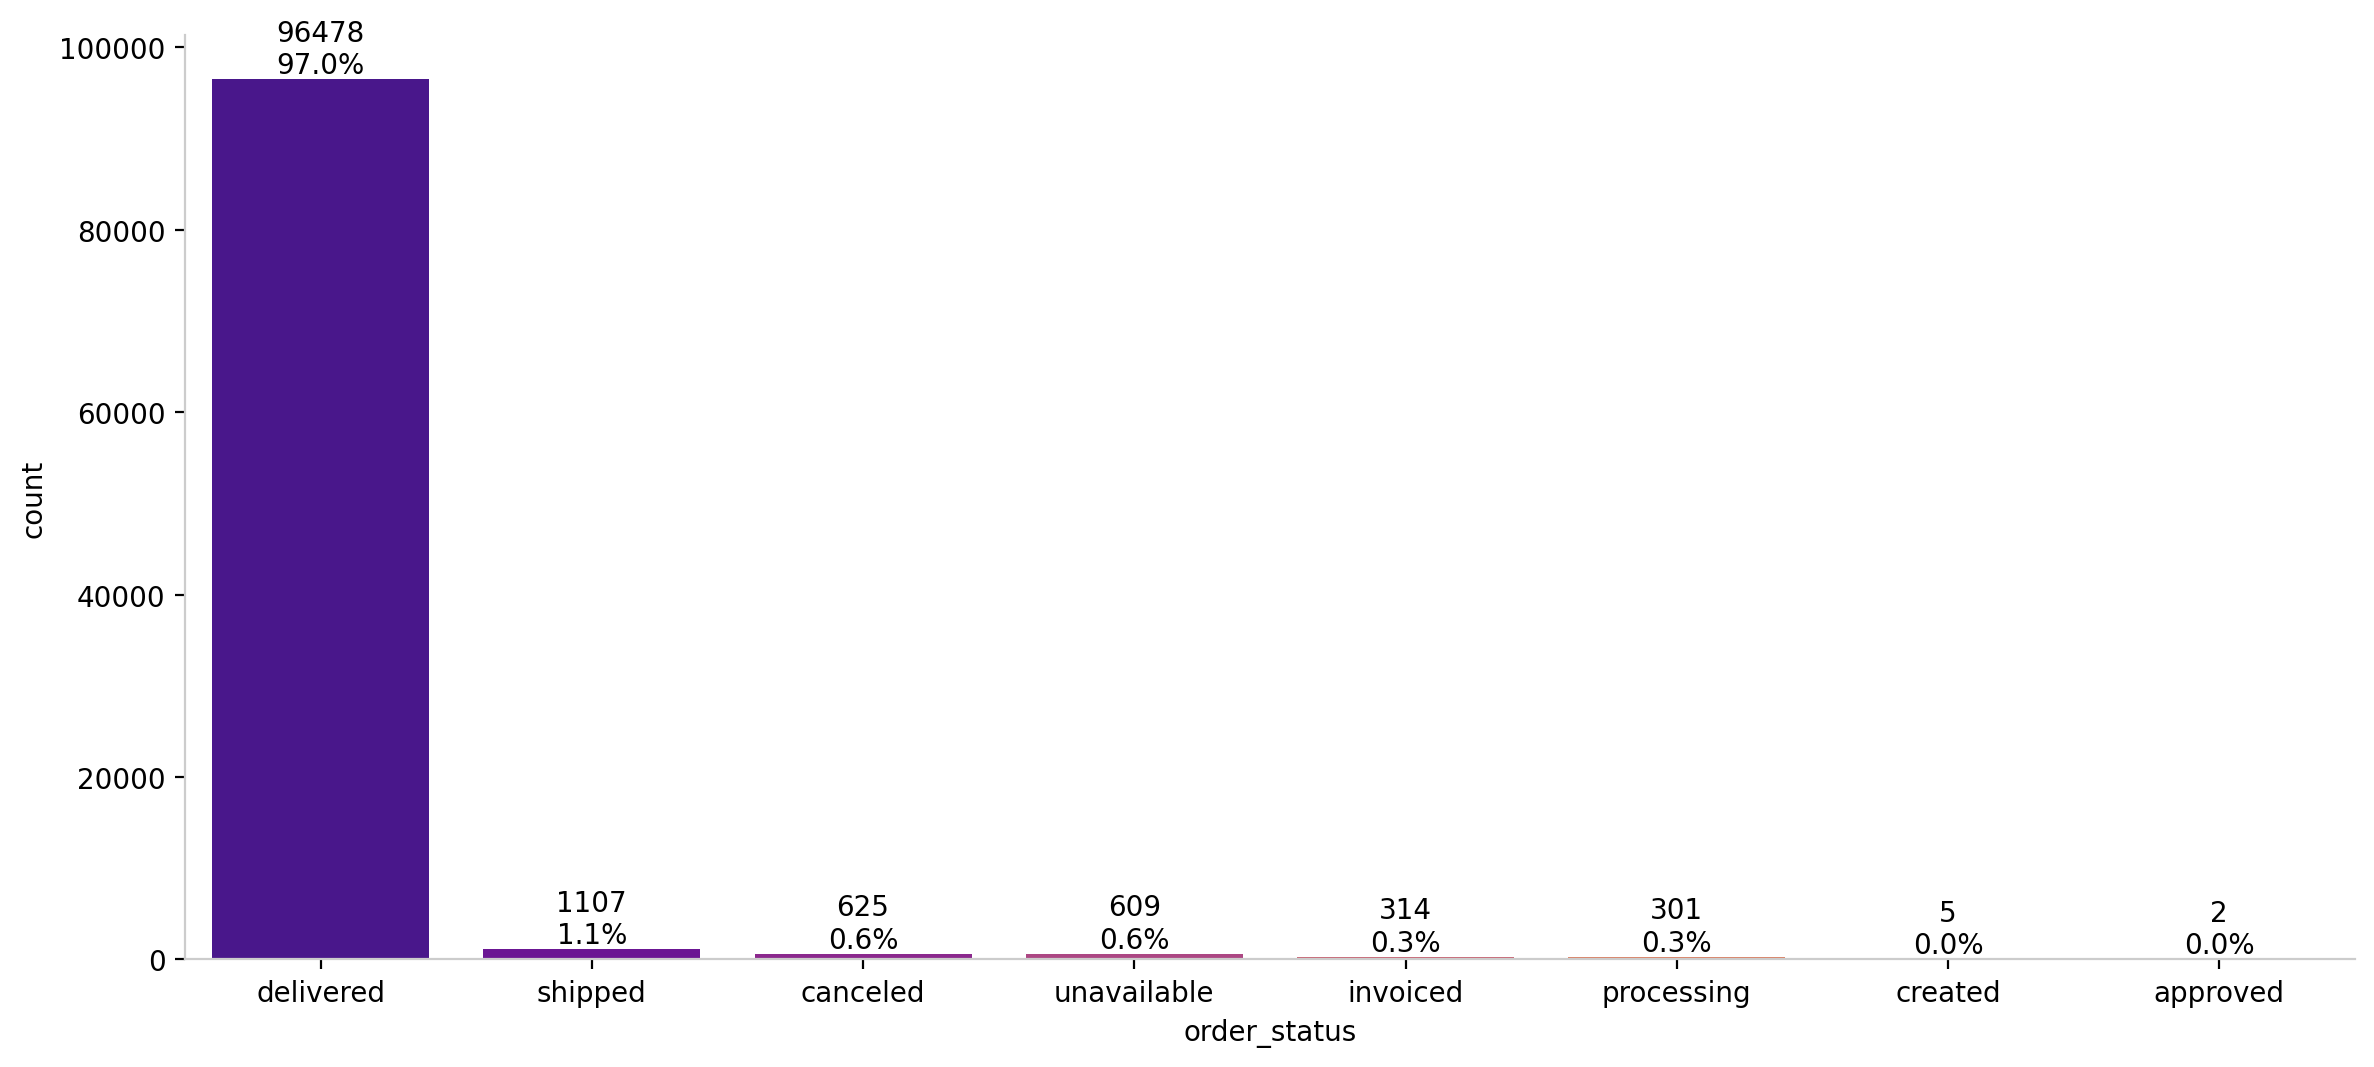

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

### Observations
- We can see that the vast majority of orders were delivered, with a negligible 3% from the other states.

___
_Comparison of orders between 2017 and 2018_
___

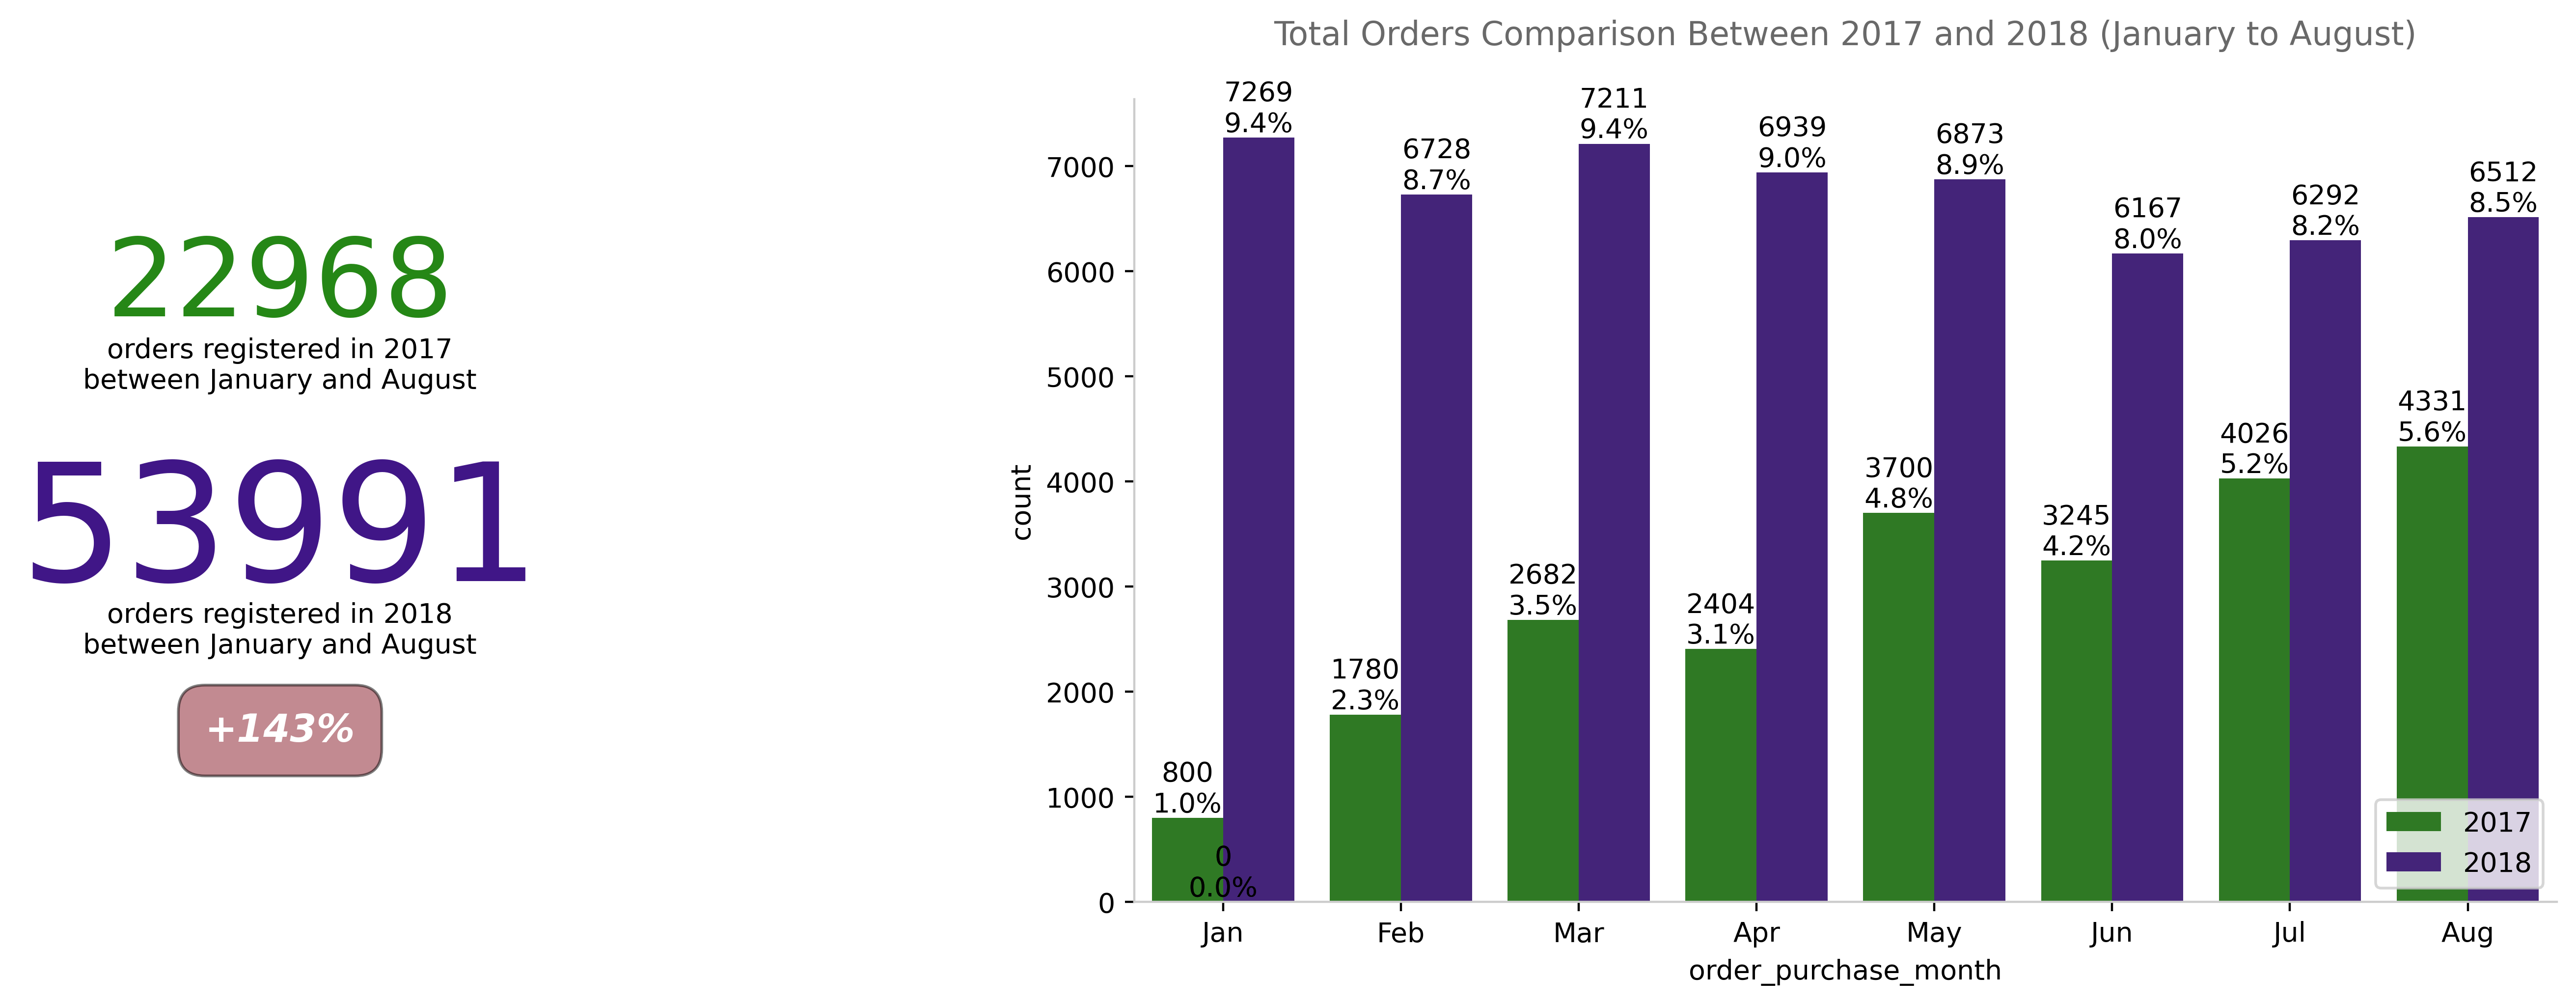

In [9]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5), dpi=200)

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='#258716', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='#401687', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='#871625', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette=['#258716','#401687'])
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

## E-Commerce around Brazil
We will use an API from the Brazilian government to get the region of each customer_state, and we will create a graph to answer interesting questions.

In [10]:
# Merging orders and order_items
df_orders_items = df_orders.merge(order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.
geo_prep = geolocation[geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  order_item_id  \
0                   10                 Morning            1.0   
1                   20                   Night            1.0   
2                    8                 Morning            1.0   
3                   19                   Night            1.0   
4                   21                   Night            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b

In [11]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

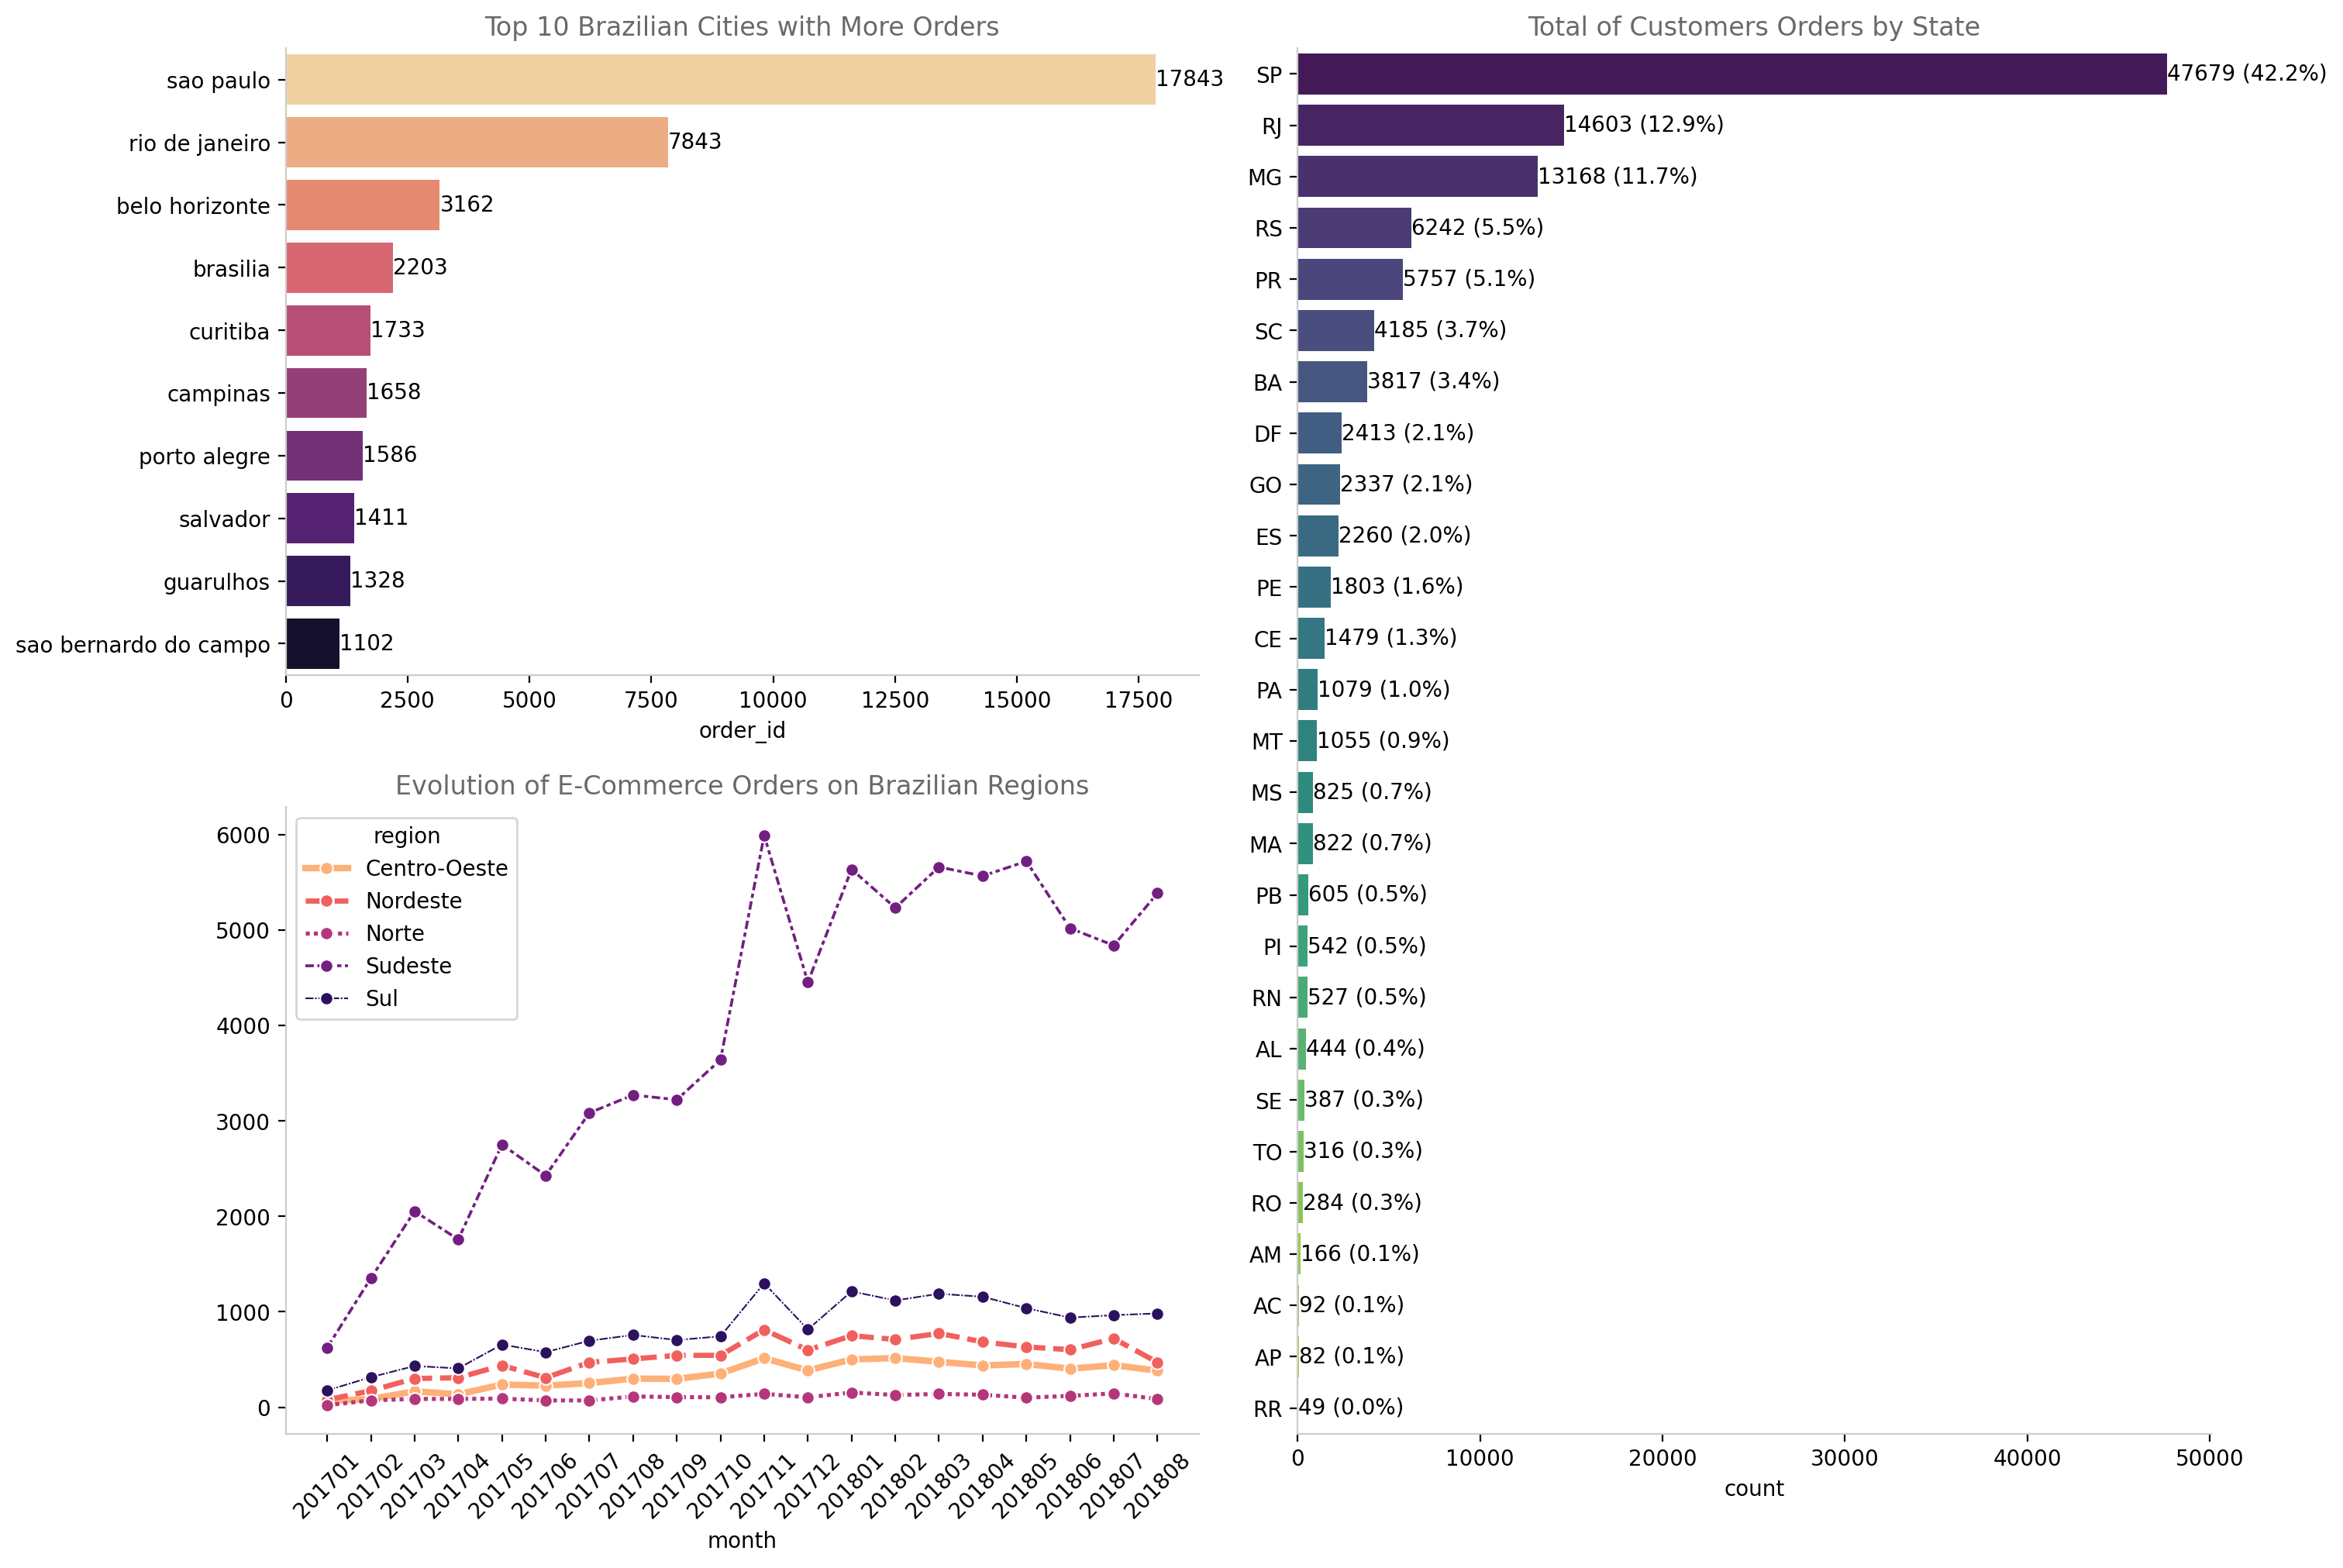

In [12]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma_r', markers=['o'])
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma_r')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

### Observations
- We can see that the region showing the most growth is the South.
- The cities with the most orders are Sao Paulo and Rio de Janeiro.

___
_Map of Brazil with order distribution (sample of 40,000 orders)_
___

In [13]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:40000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:40000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

___
_With the heatmap we can clearly see that Sao Paulo is the core of e-commerce customers in Brazil._
___

In [14]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

## E-Commerce Economy
The next step will be to analyze how money moves through e-commerce. We'll look at prices, freights, and more.

___
_Sales also increase over the time?_
___

First, we'll group our data by year and month, to see the evolution

In [15]:
df_order_items_filt = df_orders_items.copy()
df_order_items_filt.order_purchase_year_month = df_order_items_filt.order_purchase_year_month.astype('int64')

df_order_items_filt = df_order_items_filt[(df_order_items_filt.order_purchase_year_month >= 201701) & 
                                          (df_order_items_filt.order_purchase_year_month <= 201808)]

order_items_month = df_order_items_filt.groupby('order_purchase_year_month', as_index=False).agg(n_orders=('order_id','count'),
                                                             price_sum=('price','sum'),
                                                             freight_mean=('freight_value','mean'))

sales_2017 = order_items_month[(order_items_month.order_purchase_year_month <= 201708)].price_sum.sum()
sales_2018 = order_items_month[(order_items_month.order_purchase_year_month >= 201801) & (order_items_month.order_purchase_year_month < 201809)].price_sum.sum()
order_items_month.order_purchase_year_month = order_items_month.order_purchase_year_month.astype('str')
order_items_month.head()


order_purchase_year_month  n_orders  price_sum  freight_mean
0                    201701       966  120312.87     17.670806
1                    201702      1998  247303.02     19.978268
2                    201703      3041  374344.30     19.234763
3                    201704      2697  359927.23     19.558499
4                    201705      4176  506071.14     19.371327

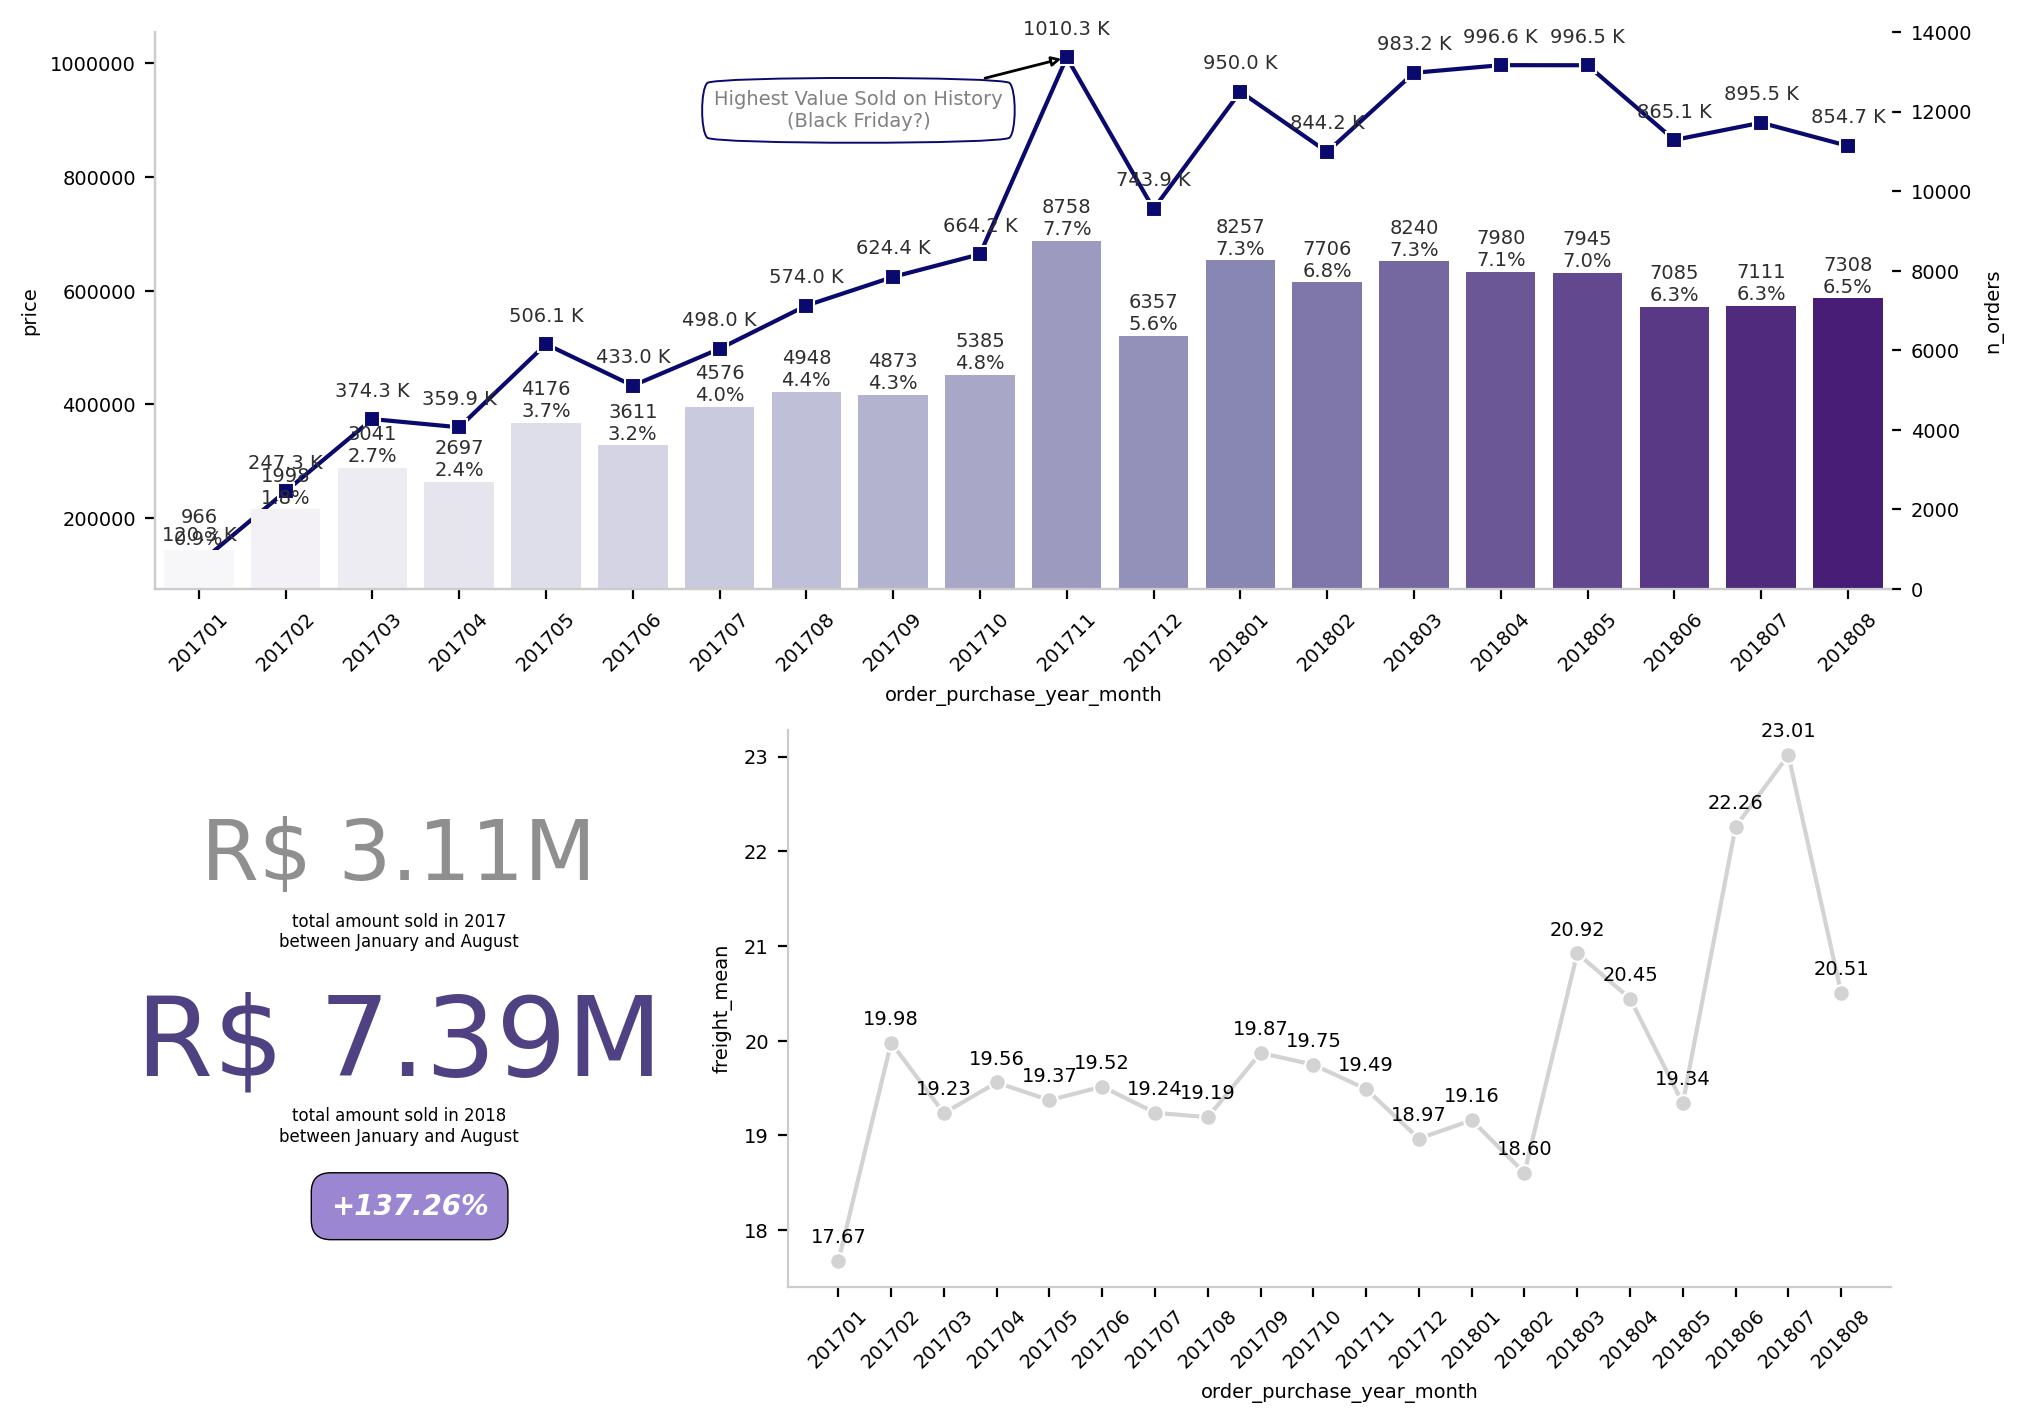

In [16]:
fig = plt.figure(constrained_layout=True, figsize=(10,7))

gs = GridSpec(2,3, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1:])


sns.lineplot(data=order_items_month, x='order_purchase_year_month', y='price_sum', marker='s', color='#09096E', ax=ax1, linewidth=1.5)
ax1.tick_params(rotation=45, axis='x')
ax1.tick_params(axis='both', labelsize='7')
ax1.set_xlabel('order_purchase_year_month', fontsize='7')
ax1.set_ylabel('price', fontsize='7')
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
ax1.ticklabel_format(style='plain', axis='y')
ax1.annotate('Highest Value Sold on History\n(Black Friday?)', xy=('201711', 1010300),xytext=(-75, -25), size=7, ha='center',
             textcoords='offset points', color='gray', bbox=dict(boxstyle='round4', fc='white', linewidth=.7, edgecolor='#09096E', pad=.7),
             arrowprops=dict(arrowstyle='-|>', fc='w'))
format_spines(ax1, right_border=False)
for x, y in zip(order_items_month.order_purchase_year_month, order_items_month.price_sum):
    ax1.text(x,y+40000,s=f'{round(y/1000,1)} K', fontsize=7, ha='center', color='#2E2E2E')

ax1_2 = ax1.twinx()
sns.barplot(data=order_items_month, x='order_purchase_year_month', y='n_orders',ax=ax1_2, palette='Purples')
ax1_2.set(ylim=(0, 14000))
ax1_2.set_ylabel('n_orders', fontsize='7')
ax1_2.tick_params(axis='y', labelsize='7')
format_spines(ax1_2, right_border=False)
total_n_orders = order_items_month.n_orders.sum()
for x, y in zip(order_items_month.order_purchase_year_month, order_items_month.n_orders):
    ax1_2.text(x,y+150,s=f'{y}\n{round((y/total_n_orders)*100,1)}%', fontsize=7, ha='center', color='#2E2E2E')

ax2.text(0.5, 0.73, f'R$ {round(sales_2017/1000000,2)}M', fontsize=30, color='#8F8F8F', ha='center')
ax2.text(0.5, 0.61, f'total amount sold in 2017\nbetween January and August', fontsize=6, color='black', ha='center')
ax2.text(0.5, 0.38, f'R$ {round(sales_2018/1000000,2)}M', fontsize=40, color='#504182', ha='center')
ax2.text(0.5, 0.26, f'total amount sold in 2018\nbetween January and August', fontsize=6, color='black', ha='center')
ax2.annotate(f'+{round(((sales_2018/sales_2017) - 1) * 100, 2)}%', xy=(.36,.13), color='white', weight='bold', style='italic', 
             bbox=dict(boxstyle='round', fc='#9B86D1', pad=.7, linewidth=.5))
ax2.axis('off')

sns.lineplot(data=order_items_month, x='order_purchase_year_month', y='freight_mean', marker='o', color='lightgray', ax=ax3)
format_spines(ax3, right_border=False)
ax3.tick_params(rotation=45, axis='x')
ax3.tick_params(axis='both', labelsize='7')
ax3.set_xlabel('order_purchase_year_month', fontsize='7')
ax3.set_ylabel('freight_mean', fontsize='7')
for x, y in zip(order_items_month['order_purchase_year_month'], order_items_month['freight_mean']):
    ax3.text(x, y + .15, f'{y:.2f}', ha='center', va='bottom', fontsize=7)

### Observations
1. It's clear that, like orders, sales have grown at the same rate (+137.26%).
2. The same peak is repeated in November (Black Friday?).
3. Shipping costs peaked in July 2018.

In [17]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

___
_How are total sales distributed across the different states of Brazil?_
___

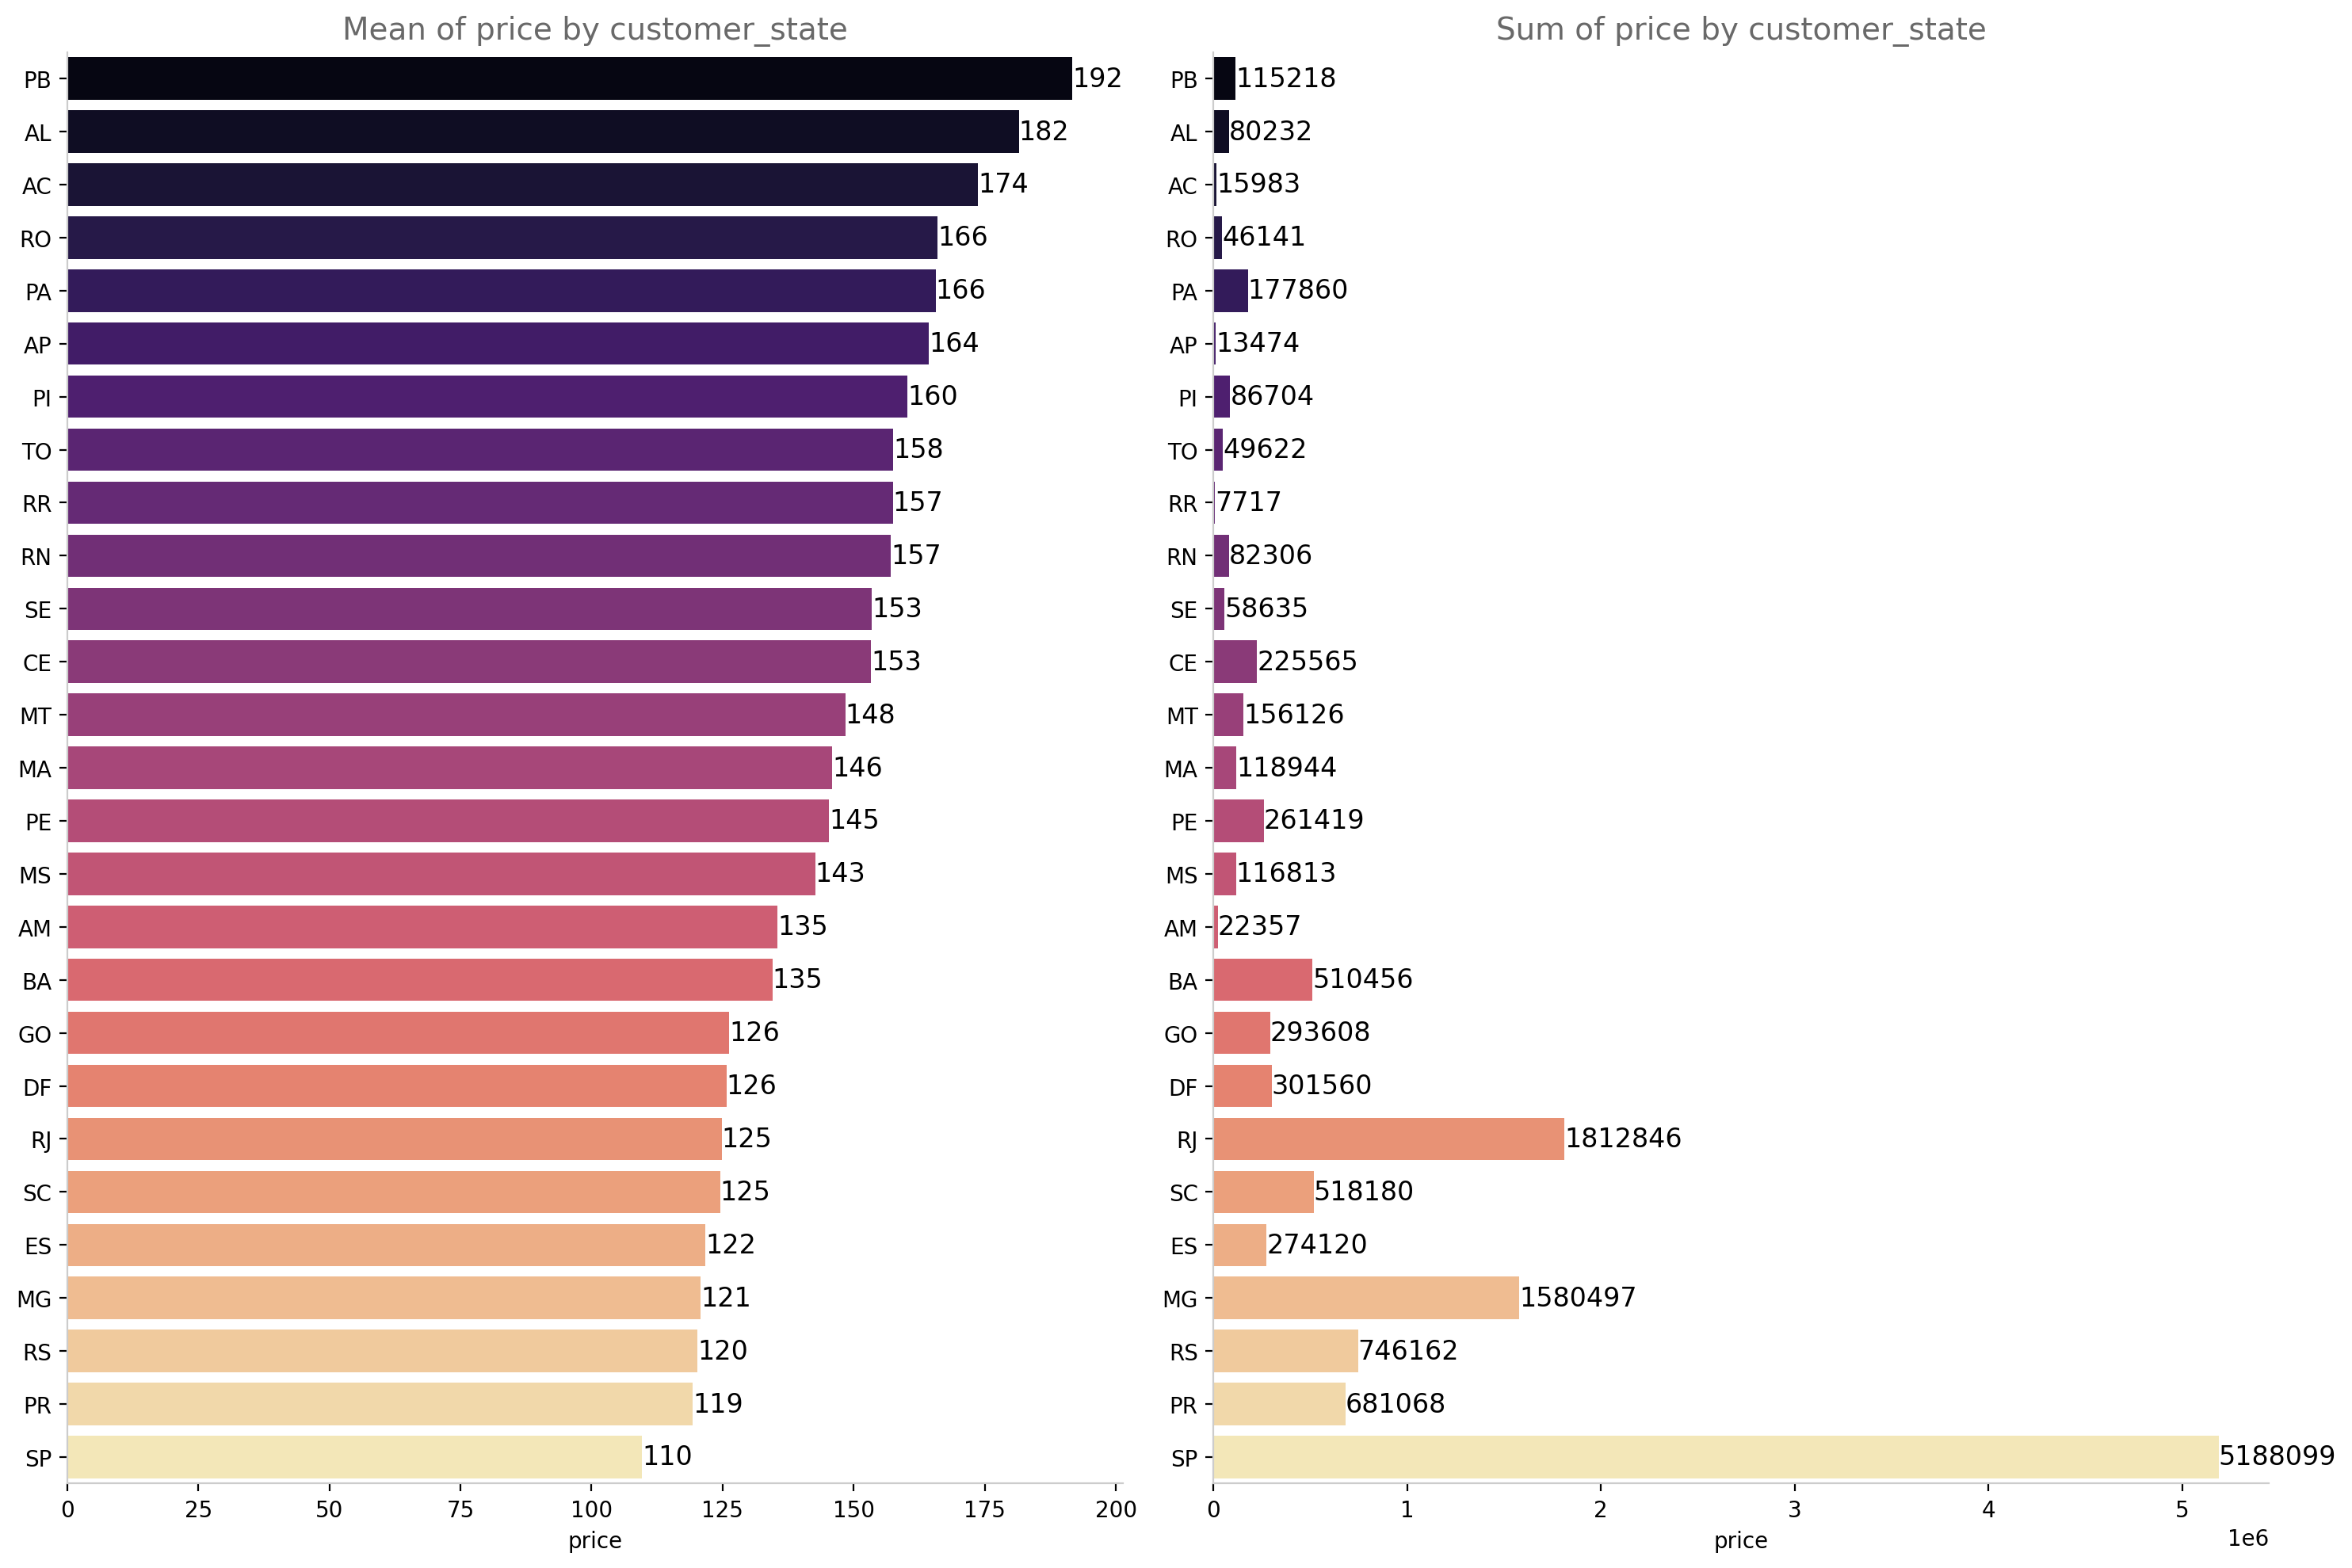

In [18]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'price', palette='magma', figsize=(15, 10))


### Observations
It is very interesting to realize how some states have a very high total sales, but the average price per order is very low, as is the case of Sao Paulo, which has the highest amount of sales (5,188,099 sold) but is also where customers pay the least (110 per order).

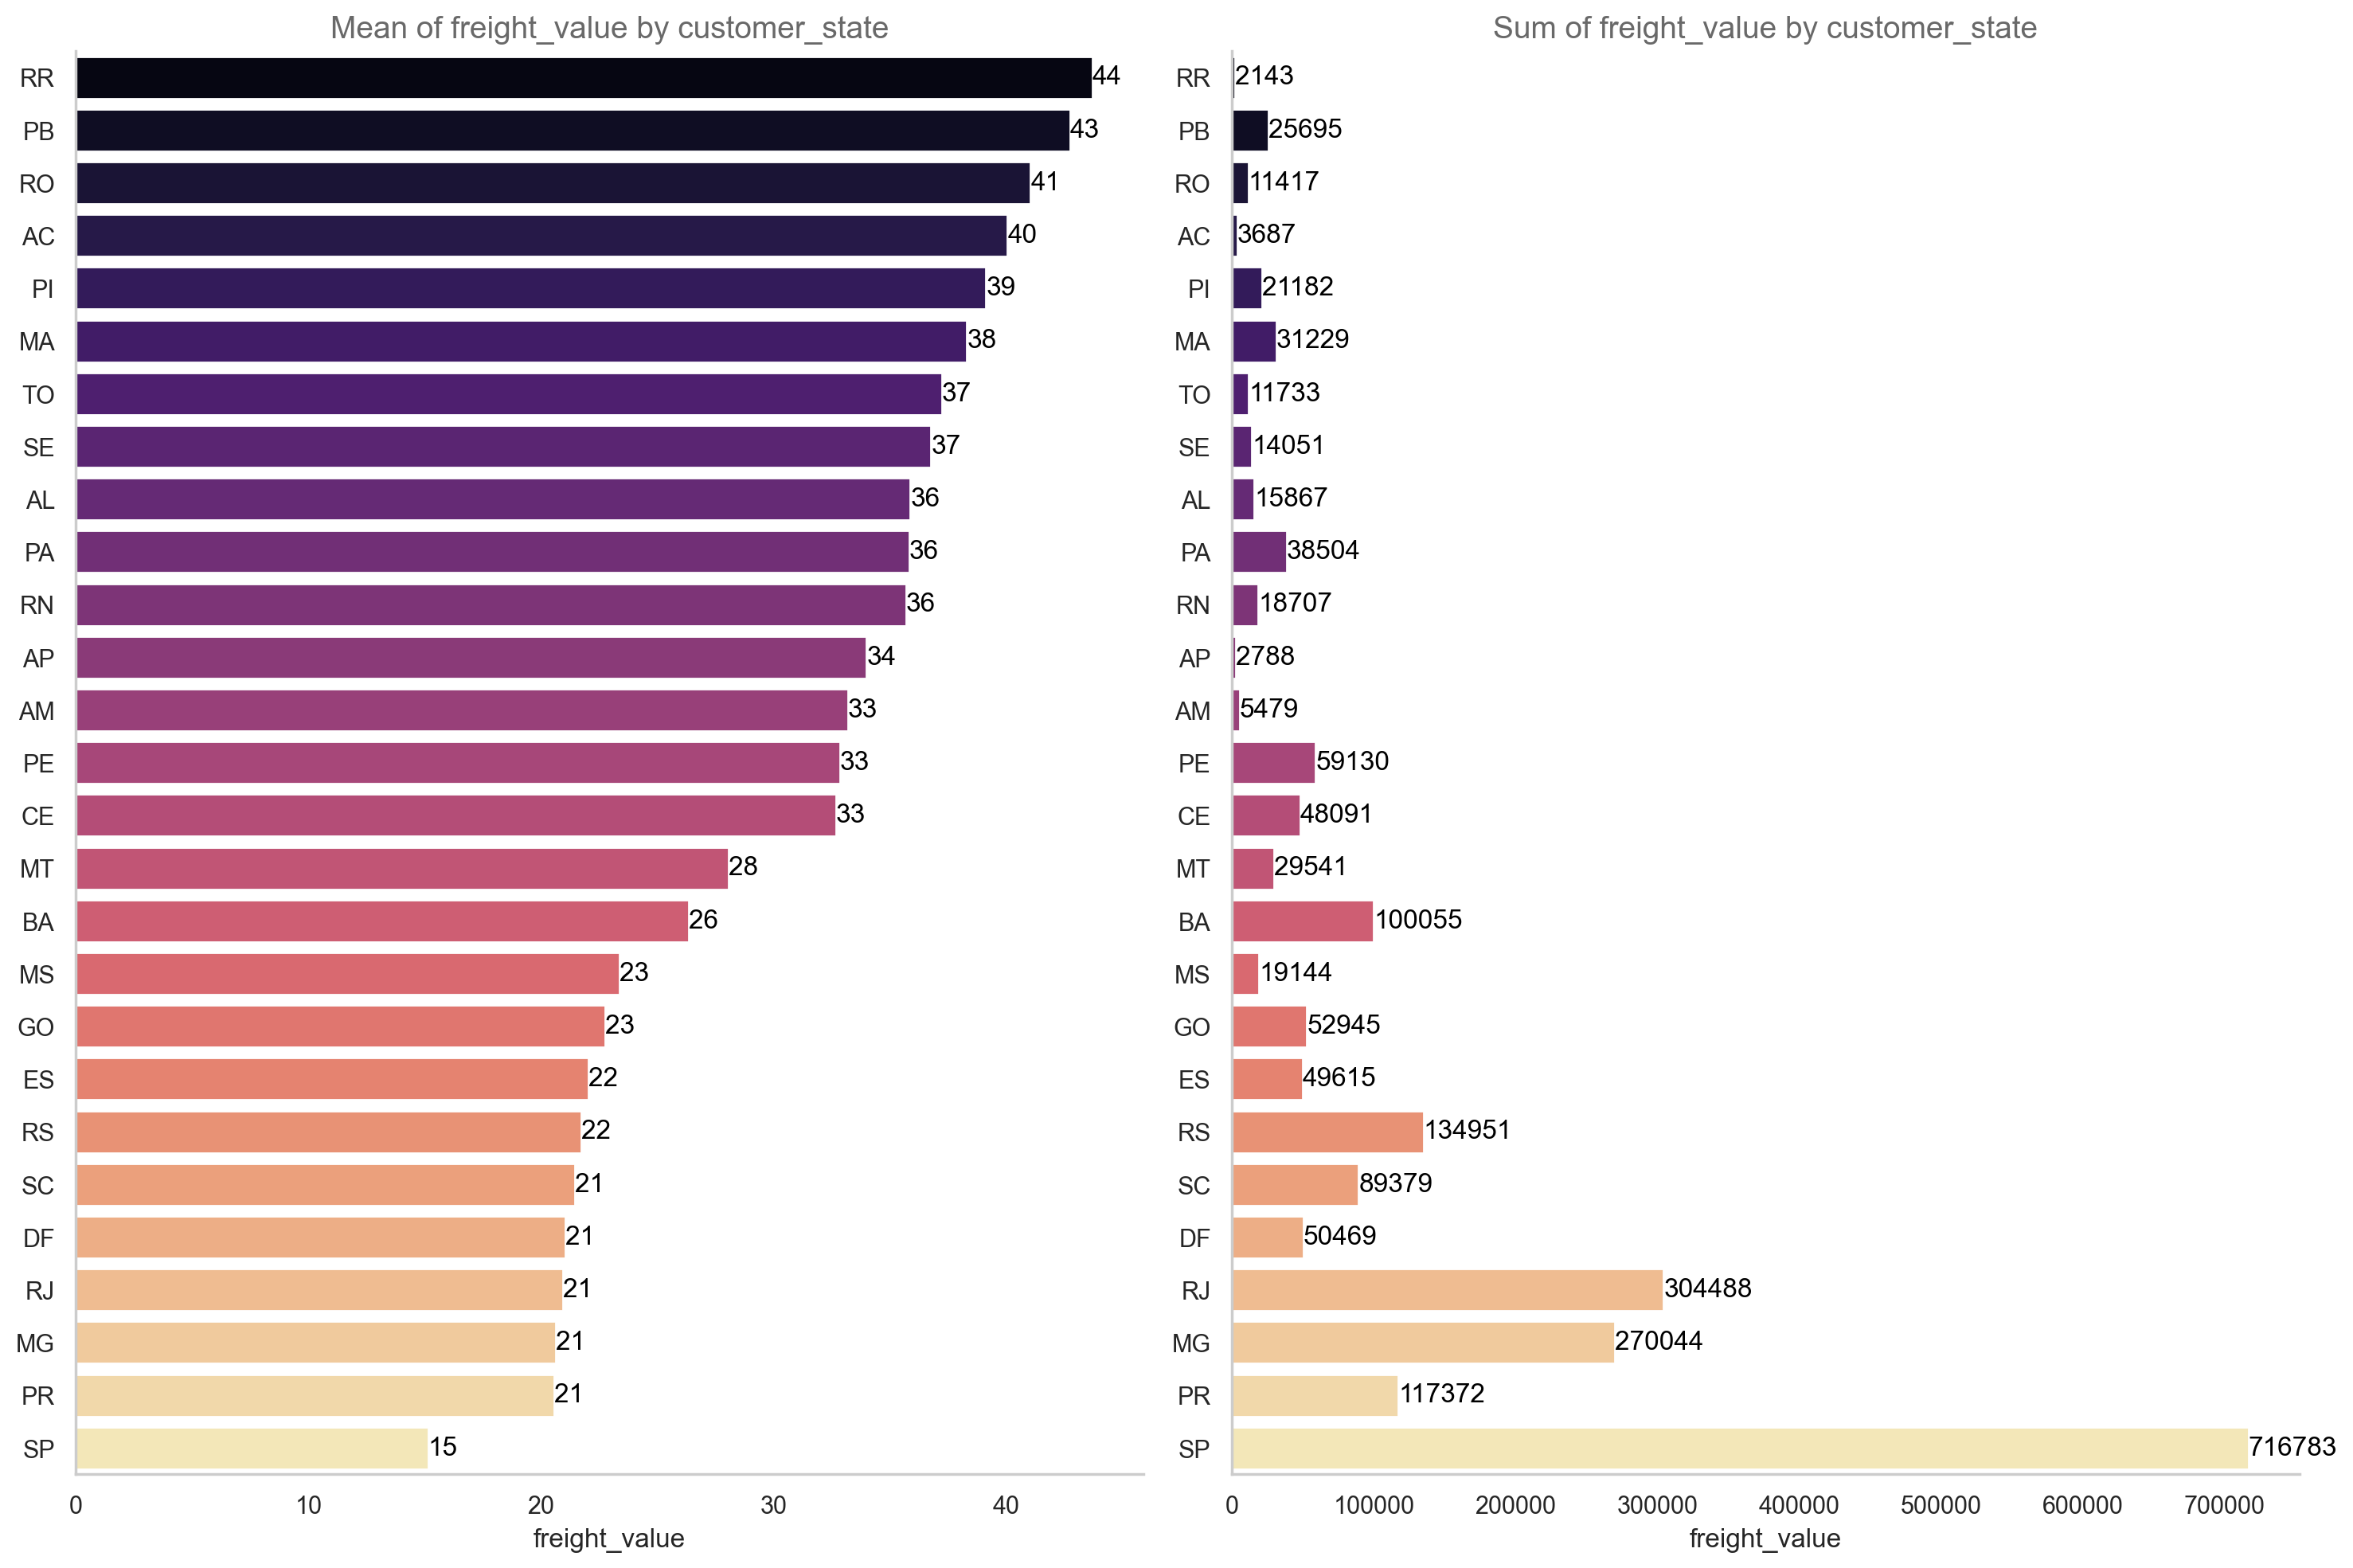

In [94]:
mean_sum_analysis(df_orders_filt, 'customer_state', 'freight_value', palette='magma', figsize=(15, 10))

### Observations
- Here we can gain insights into the states that pay the most for shipping. We can see that RR (Rorima), PB (Paraiba), RO (Rondonia), and AC (Acre) typically pay more for shipping.
- Perhaps this is why these states place more expensive orders to take advantage of shipping costs.

___
_Which are the best/worst states to buy in E-commerce in Brazil?_
___

In [20]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']

mask = purchasing.notna() & delivered.notna()
df_orders_filt['time_to_delivery'] = np.nan
df_orders_filt.loc[mask, 'time_to_delivery'] = calc_working_days(purchasing[mask], delivered[mask], convert=True)
df_orders_filt['diff_estimated_delivery'] = np.nan
df_orders_filt.loc[mask,'diff_estimated_delivery'] = calc_working_days(estimated[mask], delivered[mask],convert=True)

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False)[df_orders_filt.select_dtypes(include='number').columns].mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

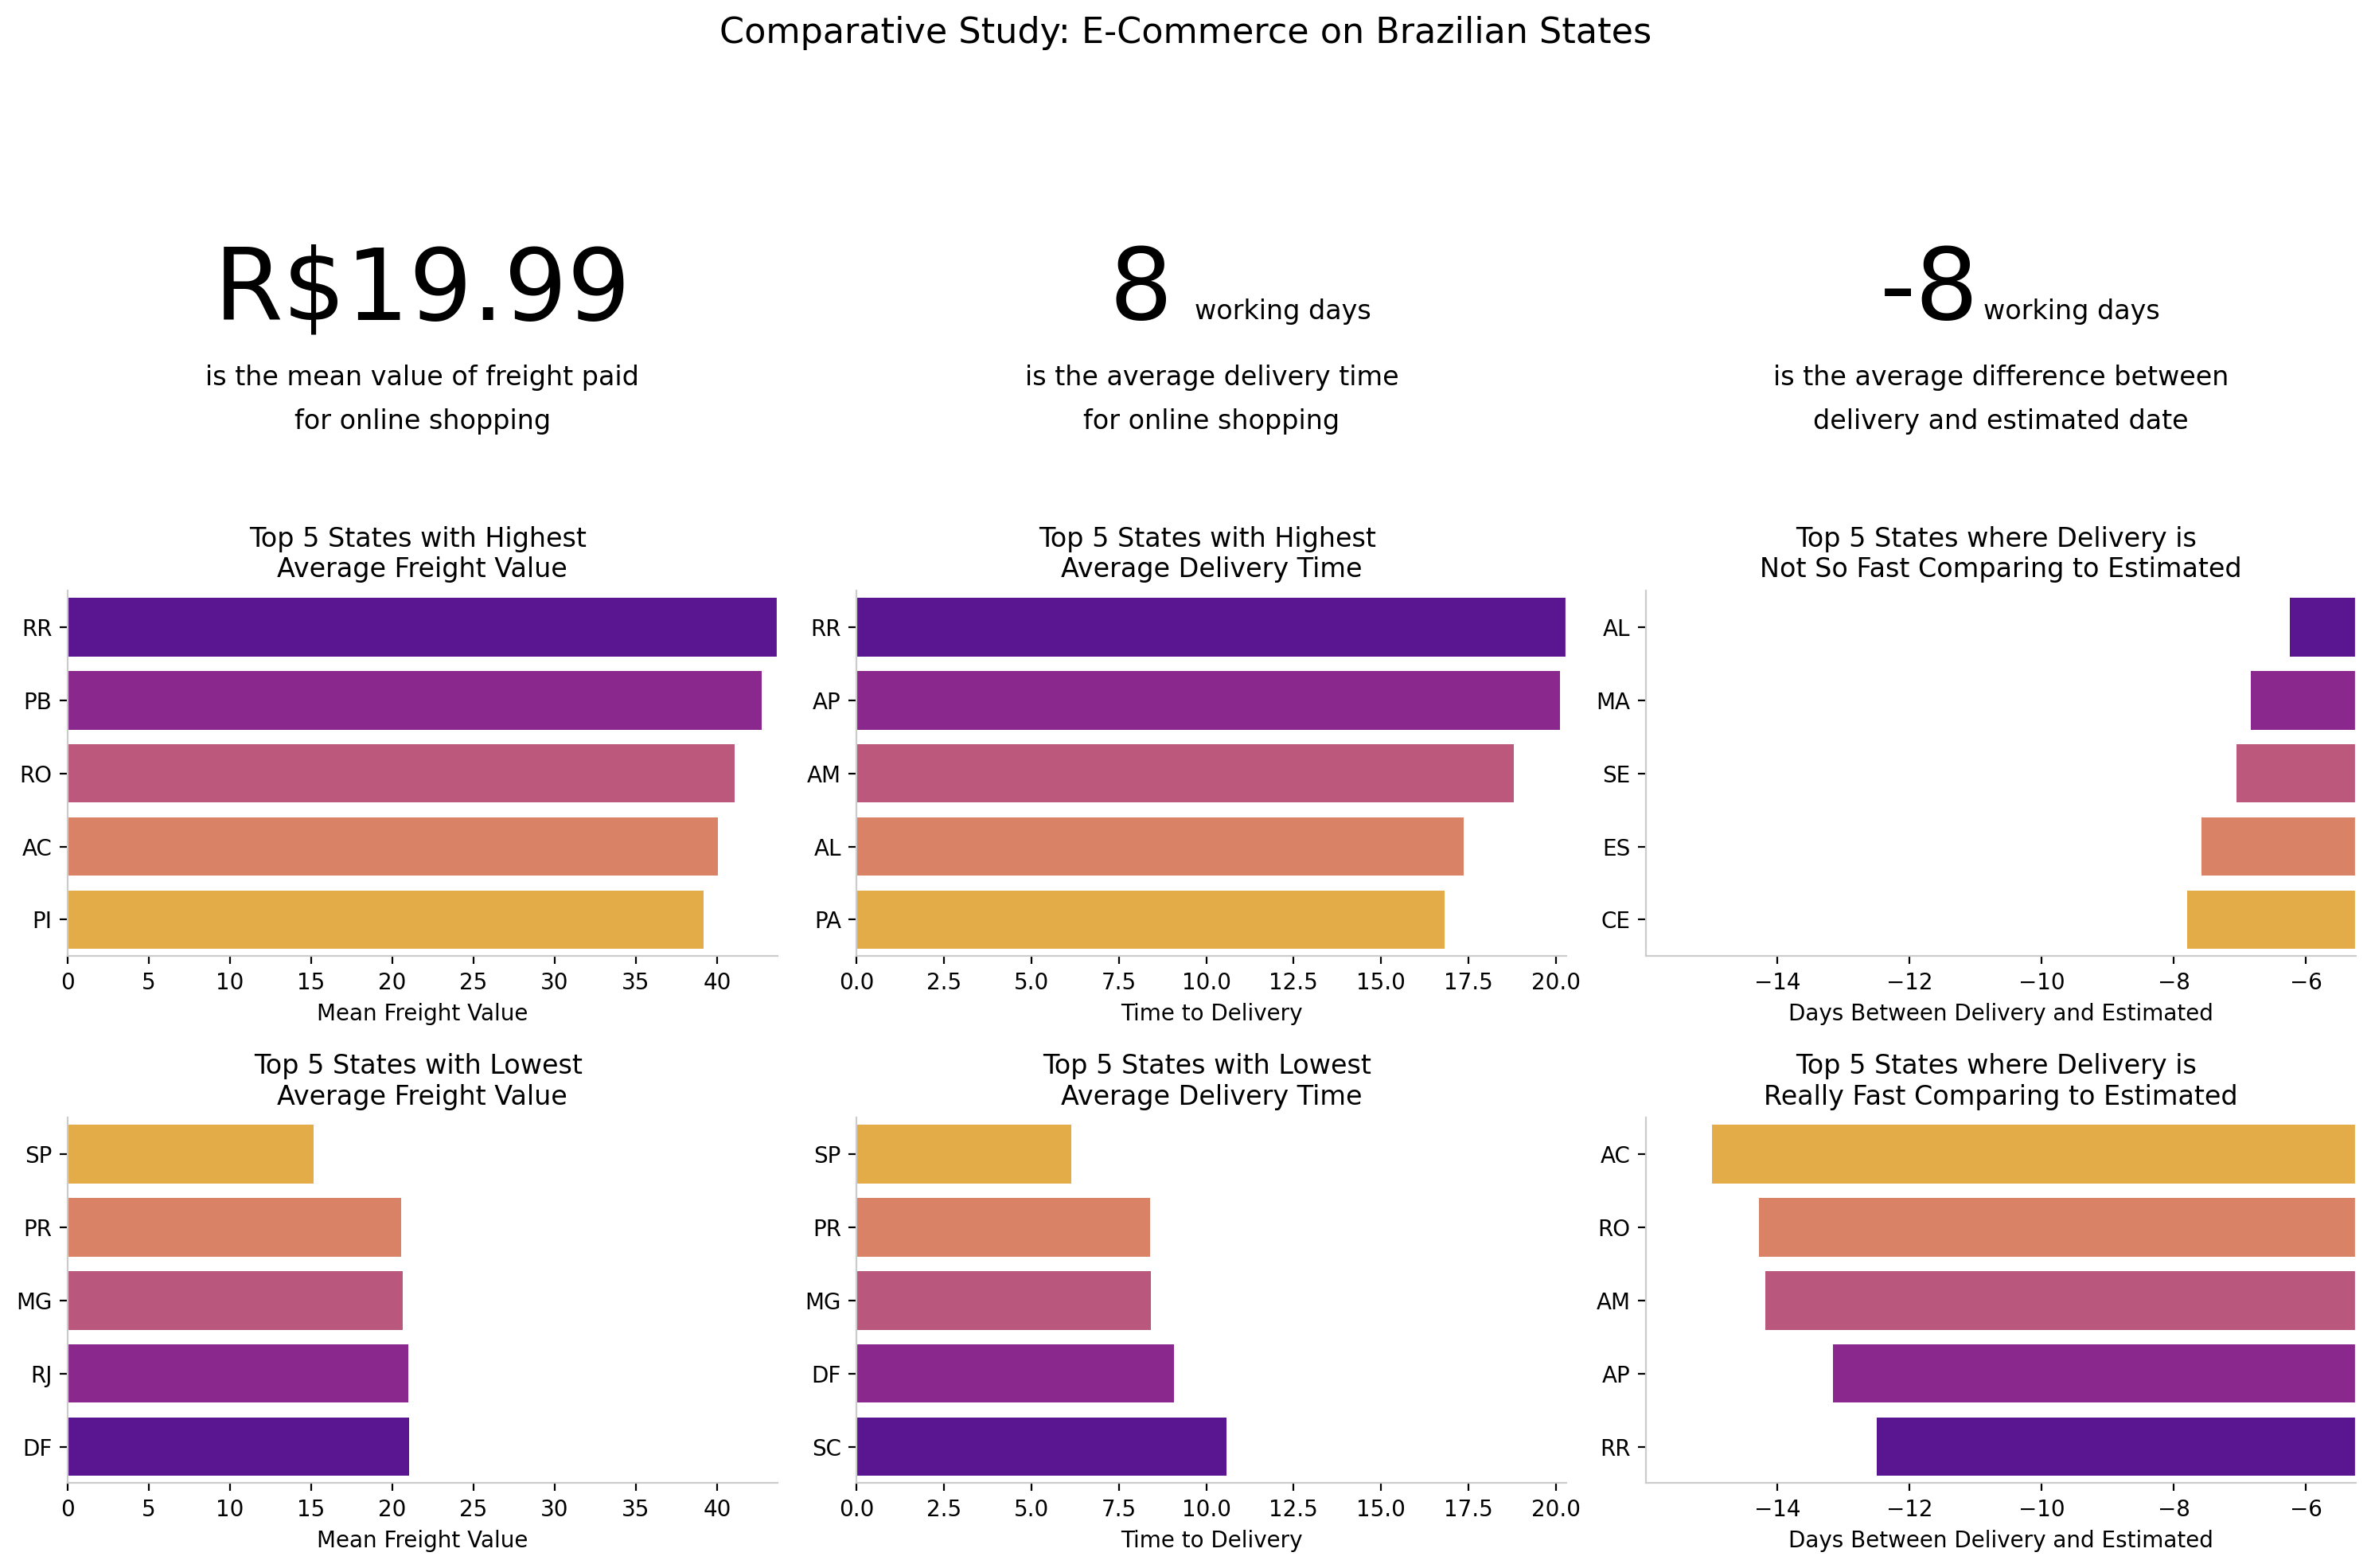

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot Pack 01 - Freight value paid on states
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.head(), ax=axs[1, 0], palette='plasma')
axs[1, 0].set_title('Top 5 States with Highest \nAverage Freight Value', size=12, color='black')
sns.barplot(x='freight_value', y='customer_state', data=states_freight_paid.tail(), ax=axs[2, 0], palette='plasma_r',order=['SP','PR','MG','RJ','DF'])
axs[2, 0].set_title('Top 5 States with Lowest \nAverage Freight Value', size=12, color='black')
for ax in axs[1, 0], axs[2, 0]:
    ax.set_xlabel('Mean Freight Value')
    ax.set_xlim(0, states_freight_paid['freight_value'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 0].text(0.50, 0.30, f'R${round(df_orders_filt.freight_value.mean(), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'is the mean value of freight paid', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 0].axis('off')

# Plot Pack 02 - Time to delivery on states
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='plasma')
axs[1, 1].set_title('Top 5 States with Highest \nAverage Delivery Time', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(), ax=axs[2, 1], palette='plasma_r',
            order=['SP','PR','MG','DF','SC'])
axs[2, 1].set_title('Top 5 States with Lowest \nAverage Delivery Time', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Time to Delivery')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')
    
# Annotations
axs[0, 1].text(0.40, 0.30, f'{int(df_orders_filt.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, 'is the average delivery time', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'for online shopping', fontsize=12, ha='center')
axs[0, 1].axis('off')
    
# Plot Pack 03 - Differnece between delivered and estimated on states
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(), ax=axs[2, 2], palette='plasma_r')
axs[2, 2].set_title('Top 5 States where Delivery is \nReally Fast Comparing to Estimated', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(), ax=axs[1, 2], palette='plasma',
            order=['AL','MA','SE', 'ES','CE'])
axs[1, 2].set_title('Top 5 States where Delivery is \nNot So Fast Comparing to Estimated', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Days Between Delivery and Estimated')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

# Annotations
axs[0, 2].text(0.40, 0.30, f'{int(df_orders_filt.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.60, 0.30, 'working days', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'is the average difference between', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'delivery and estimated date', fontsize=12, ha='center')
axs[0, 2].axis('off') 
    
plt.suptitle('Comparative Study: E-Commerce on Brazilian States', size=16)
plt.tight_layout()
plt.show()

### Observations
The best states to buy in E-commerce in Brasil are:
1. Sao Paulo (SP) have the lowest freight value (R$ 15), and the lowest delivery time (6 days)
2. Acre (AC) is delivered very quickly compared to the estimate. (-15 days)

The worst states to buy in E-commerce in Brasil are:
1. Roraima (RR) have the highest freight value (R$ 45), and the worst delivery time (20 days)
2. Alagoas (AL) is delivered very slowly compared to the estimate (-7 days)

## Payment Type Analysis

Let's now explore the payments dataset. To see how these affect e-commerce, we'll build a mini-dashboard with key concepts: `payment type` and `payment installments`. The idea is to present enough information to clarify how customers prefer to pay.

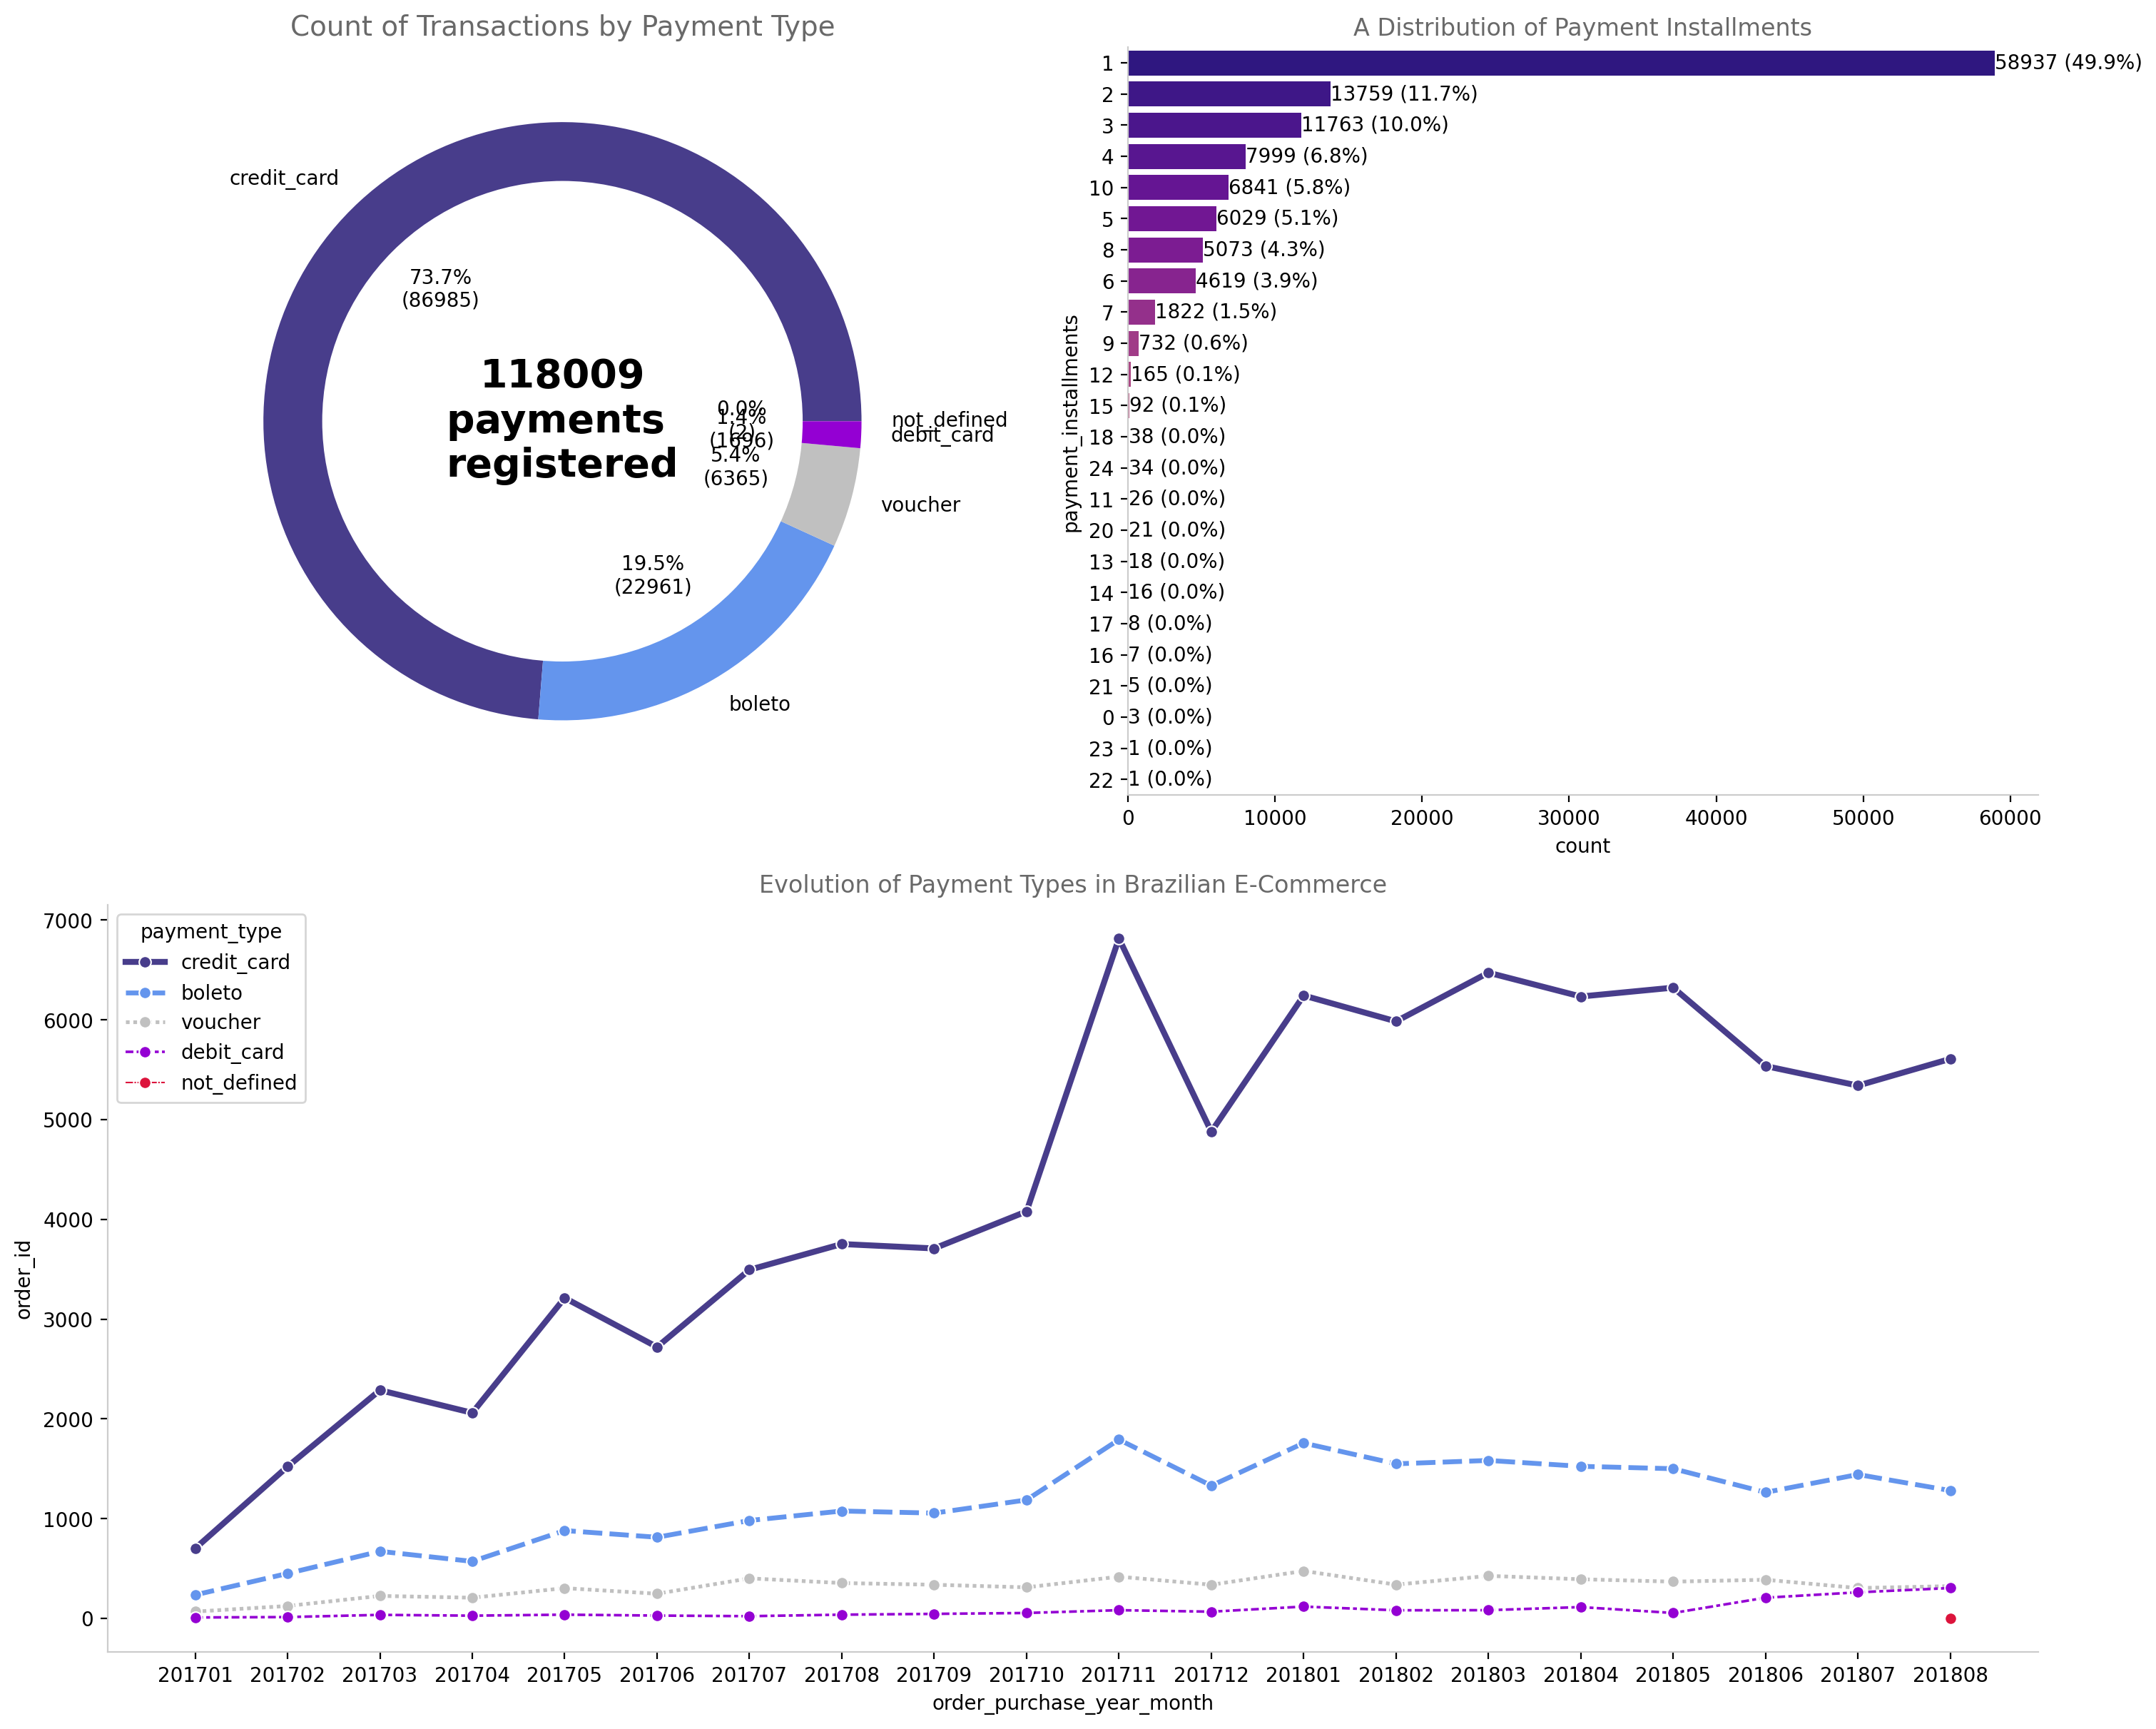

In [22]:
# Grouping data
df_orders_pay = df_orders_filt.merge(order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Plot 1 - Payment types in a donut chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
label_names = df_orders_pay['payment_type'].value_counts().index
donut_plot(df_orders_pay, col='payment_type', ax=ax1, label_names=label_names, colors=colors,
           title='Count of Transactions by Payment Type', text=f'{len(df_orders_pay)}\npayments \nregistered')
...
# Plot 2 - Payment installments
single_countplot(df_orders_pay, ax=ax2, y='payment_installments')
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=12)

# Plot 3 - Evolution of payment types
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette=colors, marker='o')
format_spines(ax3, right_border=False)
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=12, color='dimgrey')
plt.show()

We can see in the doughnut chart that customers mostly prefer to pay by credit card, but the line graph shows a slight decrease in credit card usage and an increase in debit card usage starting in May 2018, which represents an opportunity for investors to improve these services.

In the bar chart, we can see how many installments customers prefer to pay in; the majority prefer to pay in a single installment. It is important to note that a large number of customers (5.8%) prefer to pay in 10 installments.

# Natural Lenguage Processing
To further improve our relationship with data, we will begin Natural Language Processing to analyze reviews left by e-commerce customers. The goal is to use this as input for a `sentiment analysis model`, to understand customer sentiment when purchasing items online.

## Data Understanding

In [23]:
df_comments = order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


score                                            comment
0      5              Recebi bem antes do prazo estipulado.
1      5  Parabéns lojas lannister adorei comprar pela I...
2      4  aparelho eficiente. no site a marca do aparelh...
3      4    Mas um pouco ,travando...pelo valor ta Boa.\r\n
4      5  Vendedor confiável, produto ok e entrega antes...

We have approximately 41,000 reviews that we can use to train the sentiment analyzer. But to do this, we must first prepare our text and then convert it into a vector that can be interpreted by a machine learning model.

## Regular Expressions

Since we'll be receiving our comments from the internet, they'll be accompanied by HTML tags, break lines, and special characters, which we need to clean up. We'll use `Regular Expressions` to search for these patterns.

First, let's declare a function that will analyze the results of an applied regular expression. This will make it easier to validate your text preprocessing.

In [24]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list, encode=False):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        if encode == True:
            print(f"Before: \n{text_list_before[idx].encode('unicode_escape').decode()}\n")
        else:
            print(f"Before: \n{text_list_before[idx]}\n")
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

### Breakline and Carriage Return

In [25]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [26]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, encode=True, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!\r\nTudo certo!\r\n\r\nAtt \r\n\r\nElenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



In this comment, we can see the the \r (carriage return) and \n (new line) patterns. And with RegEX, we can remove them

### Sites and Hiperlinks
Another pattern that must be threated is sites and hiperlinks. Let's define another function to apply RegEx on this.

In [27]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [28]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10607])

--- Text 1 ---

Before: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 



### Dates
Another pattern we can find when working with reviews is dates. Let's look at some examples and use RegEx to replace them with `data` (date in english)

In [29]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [30]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[178, 567, 1152])

--- Text 1 ---

Before: 
A targaryen não é de confiança não entregou a minha compra e colocou no rastreamento do pedido que foi entregue no dia 14/12/17 empresa falsa quero receber meus produtos que foram pagos com boleto bancari

After: 
A targaryen não é de confiança não entregou a minha compra e colocou no rastreamento do pedido que foi entregue no dia  data  empresa falsa quero receber meus produtos que foram pagos com boleto bancari

--- Text 2 ---

Before: 
ENTREGA MUITO DEMORADA, COMPREI EM 26/03/2018 E ATÉ AGORA NÃO RECEBI OS PRODUTOS

After: 
ENTREGA MUITO DEMORADA, COMPREI EM  data  E ATÉ AGORA NÃO RECEBI OS PRODUTOS

--- Text 3 ---

Before: 
Eu comprei um celular smartphone , não chegou não recomendo comprar nesta loja targaryen e lannister porque não chegou meu produto. Eu comprei está data,07/06/2017. Era pra chegar no dia .05/07/2017.

After: 
Eu comprei um celular smartphone , não chegou não recomendo comprar nesta loja targaryen e lannister porque não chegou meu produto

### Money

Another common pattern is money ($R). To improve our model, we could replace that pattern with a key word `dinheiro` (means money or amount in English).

In [31]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [32]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[45, 10536, 29455])

--- Text 1 ---

Before: 
Este foi o pedido  Balde Com 128 Peças - Blocos De Montar 2 un - R$ 25,00 cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un - R$ 35,90 (ESTE FOI ENTREG

After: 
Este foi o pedido  Balde Com 128 Peças - Blocos De Montar 2 un -  dinheiro  cada (NÃO FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un -  dinheiro  (ESTE FOI ENTREG

--- Text 2 ---

Before: 
Valor do produto no site $175,00 mais frete de 12,73.....emitiram nota fiscal no valor de $ 137,00....inferior ao valor do site...por que?

After: 
Valor do produto no site  dinheiro  mais frete de 12,73.....emitiram nota fiscal no valor de  dinheiro ....inferior ao valor do site...por que?

--- Text 3 ---

Before: 
Óculos e um pouco fino a armação.  Mais o mesmo na loja onde fui ver estava R$380,00  Então estou no lucro a empresa entregou no prazo.  

After: 
Óculos e um pouco fino a armação.  Mais o mesmo na loja onde fu

### Numbers

Here we'll look for numbers in the comments and replace them with `numero` (means number in eglish). We could remove them altogether, but perhaps the model will learn something from this.

In [33]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [34]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



### Negation
Here we'll do something different. Later on, we'll eliminate stopwords, and we'll probably eliminate the meaning of some sentences by removing negation words like `não` (not). Therefore, it would be good to replace the negation words with a single word: `negação` (means negation in English).

In [35]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [36]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[11,12,29,32])

--- Text 1 ---

Before: 
Não gostei ! Comprei gato por lebre

After: 
 negação  gostei ! Comprei gato por lebre

--- Text 2 ---

Before: 
Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.

After: 
Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda  negação  recebi o produto.

--- Text 3 ---

Before: 
O produto não chegou no prazo estipulado e causou transtorno, pq programei a viagem de férias do meu filho, baseado no prazo. Moro na Bahia e ele em Cuiabá sozinho. Agora, a casa está vazia. 

After: 
O produto  negação  chegou no prazo estipulado e causou transtorno, pq programei a viagem de férias do meu filho, baseado no prazo. Moro na Bahia e ele em Cuiabá sozinho. Agora, a casa está vazia. 

--- Text 4 ---

Before: 
Produto bom, porém o que veio para mim não condi

### Special Characters
It is a very important step because there are too many special characters (. , : ; - ()), and an LLM works better without these.

In [37]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [38]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[0, 4, 2])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado.

After: 
Recebi bem antes do prazo estipulado 

--- Text 2 ---

Before: 
Vendedor confiável, produto ok e entrega antes do prazo.

After: 
Vendedor confiável  produto ok e entrega antes do prazo 

--- Text 3 ---

Before: 
aparelho eficiente. no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho

After: 
aparelho eficiente  no site a marca do aparelho esta impresso como  numero desinfector e ao chegar esta com outro nome   atualizar com a marca correta uma vez que é o mesmo aparelho



### Additional Whitespaces
After all the cleaning we did, a lot of white space was created, it is important to eliminate unnecessary spaces.

In [39]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [40]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
Vendedor confiável  produto ok e entrega antes do prazo 

After: 
Vendedor confiável produto ok e entrega antes do prazo

--- Text 3 ---

Before: 
meu produto chegou e ja tenho que devolver  pois está com defeito    negação  segurar carga

After: 
meu produto chegou e ja tenho que devolver pois está com defeito negação segurar carga



So far, we've achieved a dataset free of strange patterns, which we processed with RegEx, and also free of punctuation marks. In other words, we have half-cleaned text.

The next step is to apply advanced text transformations such as `stopwords` removal, `steaming`, and the `TF-IDF` matrix process. Let's start with stopwords.

## Stopwords

These are common words without much meaning (like the, and, of, a, is) that are removed in NLP to focus on the important words.

``stopwords`` module help us to obtain this words in Portuguese

In [41]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [42]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [43]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero Peças Blocos De Montar numero un dinheiro cada negação FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva Nº Letras numero Peças Crianças numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

--- Text 3 ---

Before: 
Chegou um pouco antes do prazo isso é bom

After: 
chegou pouco antes prazo bom



### Steaming
It is the process of reducing words to their root or base form by removing suffixes or prefixes. For example:
- running, runs, ran → run
- studies, studying → study

In [44]:
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

In [45]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



## Feature Extraction
Well, once we have passe through RegEx, stopwords removal and stemming application, to give more meaning for the text we are analysing, we can use approachs like _Bag of Words_, _TF-IDF_ and _Word2Vec_. For make our analysis easier, let's define a function that receives a text and a `vectorizer` object and applies the feature extraction on the respective text.

In [46]:
def extract_features_from_corpus(text, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(text).toarray()
    features_names = vectorizer.get_feature_names_out()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

### ContVectorizer

On the _Bag of Words_ approach, we create a dicitonary vocabulary with all the unique words and, for each word in each comment/text string, we index the words into a vector that represents the occurence (1) or not (0) of each word. This is a way for transforming a text into a frequency vector considering a literal bag of words (dictionary vocabulary).

In [47]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


abr  acab  ach  acontec  acord  ador  adquir  agor  aguard  aind  algum  \
0    0     0    0        0      0     0       0     0       0     0      0   
1    0     0    0        0      0     1       0     0       0     0      0   
2    0     0    0        0      0     0       0     0       0     0      0   
3    0     0    0        0      0     0       0     0       0     0      0   
4    0     0    0        0      0     0       0     0       0     0      0   

   além  amass  ame  ant  anunci  anúnci  aparelh  apen  apes  após  assim  \
0     0      0    0    1       0       0        0     0     0     0      0   
1     0      0    0    0       0       0        0     0     0     0      0   
2     0      0    0    0       0       0        3     0     0     0      0   
3     0      0    0    0       0       0        0     0     0     0      0   
4     0      0    0    1       0       0        0     0     0     0      0   

   ate  atend  atras  avali  avis  baix  baratheon  bast  bem  boa  bols  bom  \
0    0      0      0      0     0     0          0     0    1    0     0    0   
1    0      0      0      0     0     0          0     0    0    0     0    0   
2    0      0      0      0     0     0          0     0    0    0     0    0   
3    0      0      0      0     0     0          0     0    0    1     0    0   
4    0      0      0      0     0     0          0     0    0    0     0    0   

   bonit  busc  cab  cad  cade  caix  cancel  cap  car  cart  cartuch  cas  \
0      0     0    0    0     0     0       0    0    0     0        0    0   
1      0     0    0    0     0     0       0    0    0     0        0    0   
2      0     0    0    0     0     0       0    0    0     0        0    0   
3      0     0    0    0     0     0       0    0    0     0        0    0   
4      0     0    0    0     0     0       0    0    0     0        0    0   

   celul  cert  cheg  client  ...  sab  satisf  satisfeit  segund  sei  seman  \
0      0     0     0       0  ...    0       0          0       0    0      0   
1      0     0     0       0  ...    0       0          0       0    0      0   
2      0     0     1       0  ...    0       0          0       0    0      0   
3      0     0     0       0  ...    0       0          0       0    0      0   
4      0     0     0       0  ...    0       0          0       0    0      0   

   sempr  send  serviç  sid  sim  sit  so  sobr  solicit  solt  soment  stark  \
0      0     0       0    0    0    0   0     0        0     0       0      0   
1      0     0       0    0    0    0   0     0        0     0       0      0   
2      0     0       0    0    0    1   0     0        0     0       0      0   
3      0     0       0    0    0    0   0     0        0     0       0      0   
4      0     0       0    0    0    0   0     0        0     0       0      0   

   sup  super  tamanh  tapet  targaryen  tec  temp  tent  ter  test  tod  \
0    0      0       0      0          0    0     0     0    0     0    0   
1    0      0       0      0          0    0     0     0    0     0    1   
2    0      0       0      0          0    0     0     0    0     0    0   
3    0      0       0      0          0    0     0     0    0     0    0   
4    0      0       0      0          0    0     0     0    0     0    0   

   total  trabalh  transport  troc  tud  unidad  us  uso  vai  val  vc  vei  \
0      0        0          0     0    0       0   0    0    0    0   0    0   
1      0        0          0     0    0       0   0    0    0    0   0    0   
2      0        0          0     0    0       0   0    0    0    0   0    0   
3      0        0          0     0    0       0   0    0    0    1   0    0   
4      0        0          0     0    0       0   0    0    0    0   0    0   

   vem  vend  ver  vez  vier  volt  vou  ótim  únic  
0    0     0    0    0     0     0    0     0     0  
1    0     0    0    0     0     0    0     0     0  
2    0     0    0    1     0     0    0  

### TF-IDF

With Bag of Words, all words had the same weight, which may not always be true, especially for words with very low frequency in the corpus. Therefore, the TF-IDF (Term Frequency and Inverse Document Frequency) approach can be used with the scikit-learn library by following the formulas below:

$$TF=\frac{\text{Frequency of a word in the document}}{\text{Total words in the document}}$$

$$IDF = \log\left({\frac{\text{Total number of docs}}{\text{Number of docs containing the words}}}\right)$$

In [48]:
# Creating an object for the TfidfVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of DataFrame of corpus features:


abr  acab  ach  acontec  acord      ador  adquir  agor  aguard  aind  \
0  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
1  0.0   0.0  0.0      0.0    0.0  0.319302     0.0   0.0     0.0   0.0   
2  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
3  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   
4  0.0   0.0  0.0      0.0    0.0  0.000000     0.0   0.0     0.0   0.0   

   algum  além  amass  ame       ant  anunci  anúnci   aparelh  apen  apes  \
0    0.0   0.0    0.0  0.0  0.350927     0.0     0.0  0.000000   0.0   0.0   
1    0.0   0.0    0.0  0.0  0.000000     0.0     0.0  0.000000   0.0   0.0   
2    0.0   0.0    0.0  0.0  0.000000     0.0     0.0  0.758604   0.0   0.0   
3    0.0   0.0    0.0  0.0  0.000000     0.0     0.0  0.000000   0.0   0.0   
4    0.0   0.0    0.0  0.0  0.283249     0.0     0.0  0.000000   0.0   0.0   

   após  assim  ate  atend  atras  avali  avis  baix  baratheon  bast  \
0   0.0    0.0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0   
1   0.0    0.0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0   
2   0.0    0.0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0   
3   0.0    0.0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0   
4   0.0    0.0  0.0    0.0    0.0    0.0   0.0   0.0        0.0   0.0   

        bem       boa  bols  bom  bonit  busc  cab  cad  cade  caix  cancel  \
0  0.427576  0.000000   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0   
1  0.000000  0.000000   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0   
2  0.000000  0.000000   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0   
3  0.000000  0.510303   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0   
4  0.000000  0.000000   0.0  0.0    0.0   0.0  0.0  0.0   0.0   0.0     0.0   

   cap  car  cart  cartuch  cas  celul  cert      cheg  client  ...  sab  \
0  0.0  0.0   0.0      0.0  0.0    0.0   0.0  0.000000     0.0  ...  0.0   
1  0.0  0.0   0.0      0.0  0.0    0.0   0.0  0.000000     0.0  ...  0.0   
2  0.0  0.0   0.0      0.0  0.0    0.0   0.0  0.109305     0.0  ...  0.0   
3  0.0  0.0   0.0      0.0  0.0    0.0   0.0  0.000000     0.0  ...  0.0   
4  0.0  0.0   0.0      0.0  0.0    0.0   0.0  0.000000     0.0  ...  0.0   

   satisf  satisfeit  segund  sei  seman  sempr  send  serviç  sid  sim  \
0     0.0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0   
1     0.0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0   
2     0.0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0   
3     0.0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0   
4     0.0        0.0     0.0  0.0    0.0    0.0   0.0     0.0  0.0  0.0   

        sit   so  sobr  solicit  solt  soment  stark  sup  super  tamanh  \
0  0.000000  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0   
1  0.000000  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0   
2  0.172491  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0   
3  0.000000  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0   
4  0.000000  0.0   0.0      0.0   0.0     0.0    0.0  0.0    0.0     0.0   

   tapet  targaryen  tec  temp  tent  ter  test       tod  total  trabalh  \
0    0.0        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0   
1    0.0        0.0  0.0   0.0   0.0  0.0   0.0  0.313052    0.0      0.0   
2    0.0        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0   
3    0.0        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0   
4    0.0        0.0  0.0   0.0   0.0  0.0   0.0  0.000000    0.0      0.0   

   transport  troc  tud  unidad   us  uso  vai      val   vc  vei  vem  \
0        0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0   
1        0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0   
2        0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.00000  0.0  0.0  0.0   
3        0.0   0.0  0.0     0.0  0.0  0.0  0.

The attributes used during the instancing of each vectorizer objects can be explained as:

- `max_features=300`: indicates that the matrix will be created using the 300 most common words from the corpus
- `max_df=0.8`: indicates that we will use only words with at least 80% frequency in the corpus
- `min_df=7`: indicates that we will use only words that occurs in at least 7 text strings in the corpus

## Labelling Data

For training a sentimental analysis model, we must need the label to apply in a supervisioned Machine Learning approach. The dataset we doesn't have a clearly label saying wich comment is positive or negative. For doing that, probably the best approach is to look at individual comments and label it handly with 1 (positive comment) and 0 (negative comment) but, thinking in a fast implementation, we will use the `review_score` column to label our data into those two classes. Let's take a look.

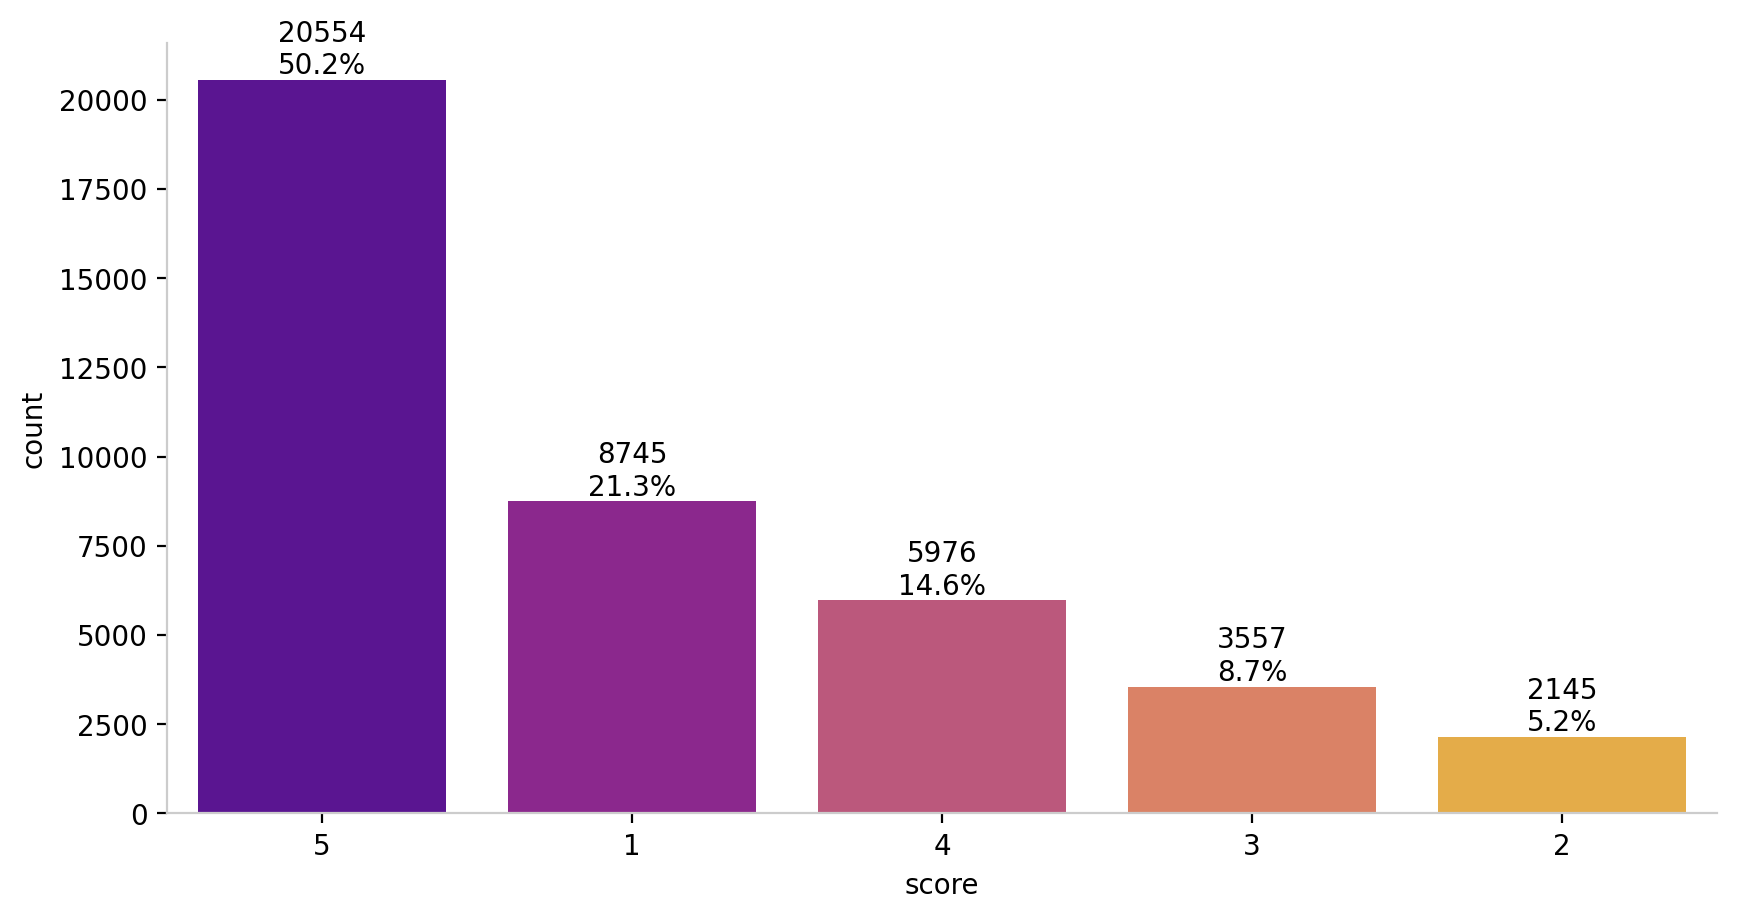

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='score', df=df_comments, ax=ax)

In this approach, let's consider that every comment with scores 1, 2 and 3 are negative comments. In the other hand, comments with score 4 and 5 will be considered as positive. Again, probably this is not the best way to train a sentimental analysis model, but for fastness, we will do this assumption and see if we can extract value from it.

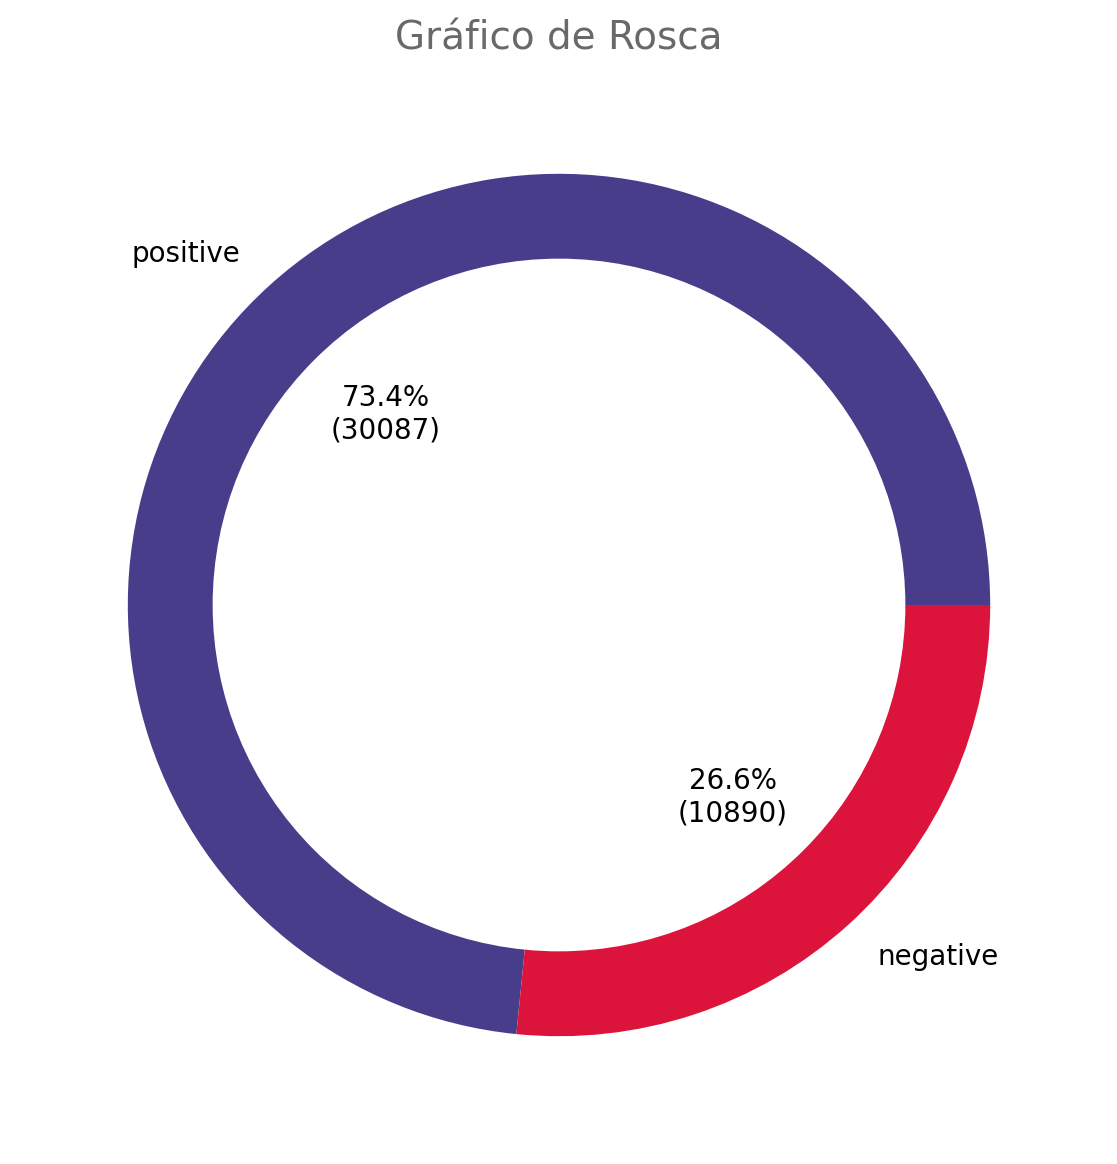

In [50]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

___
* _What's the main n-grams presentes in corpus on positive and negative classes?_
___

In [51]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [52]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

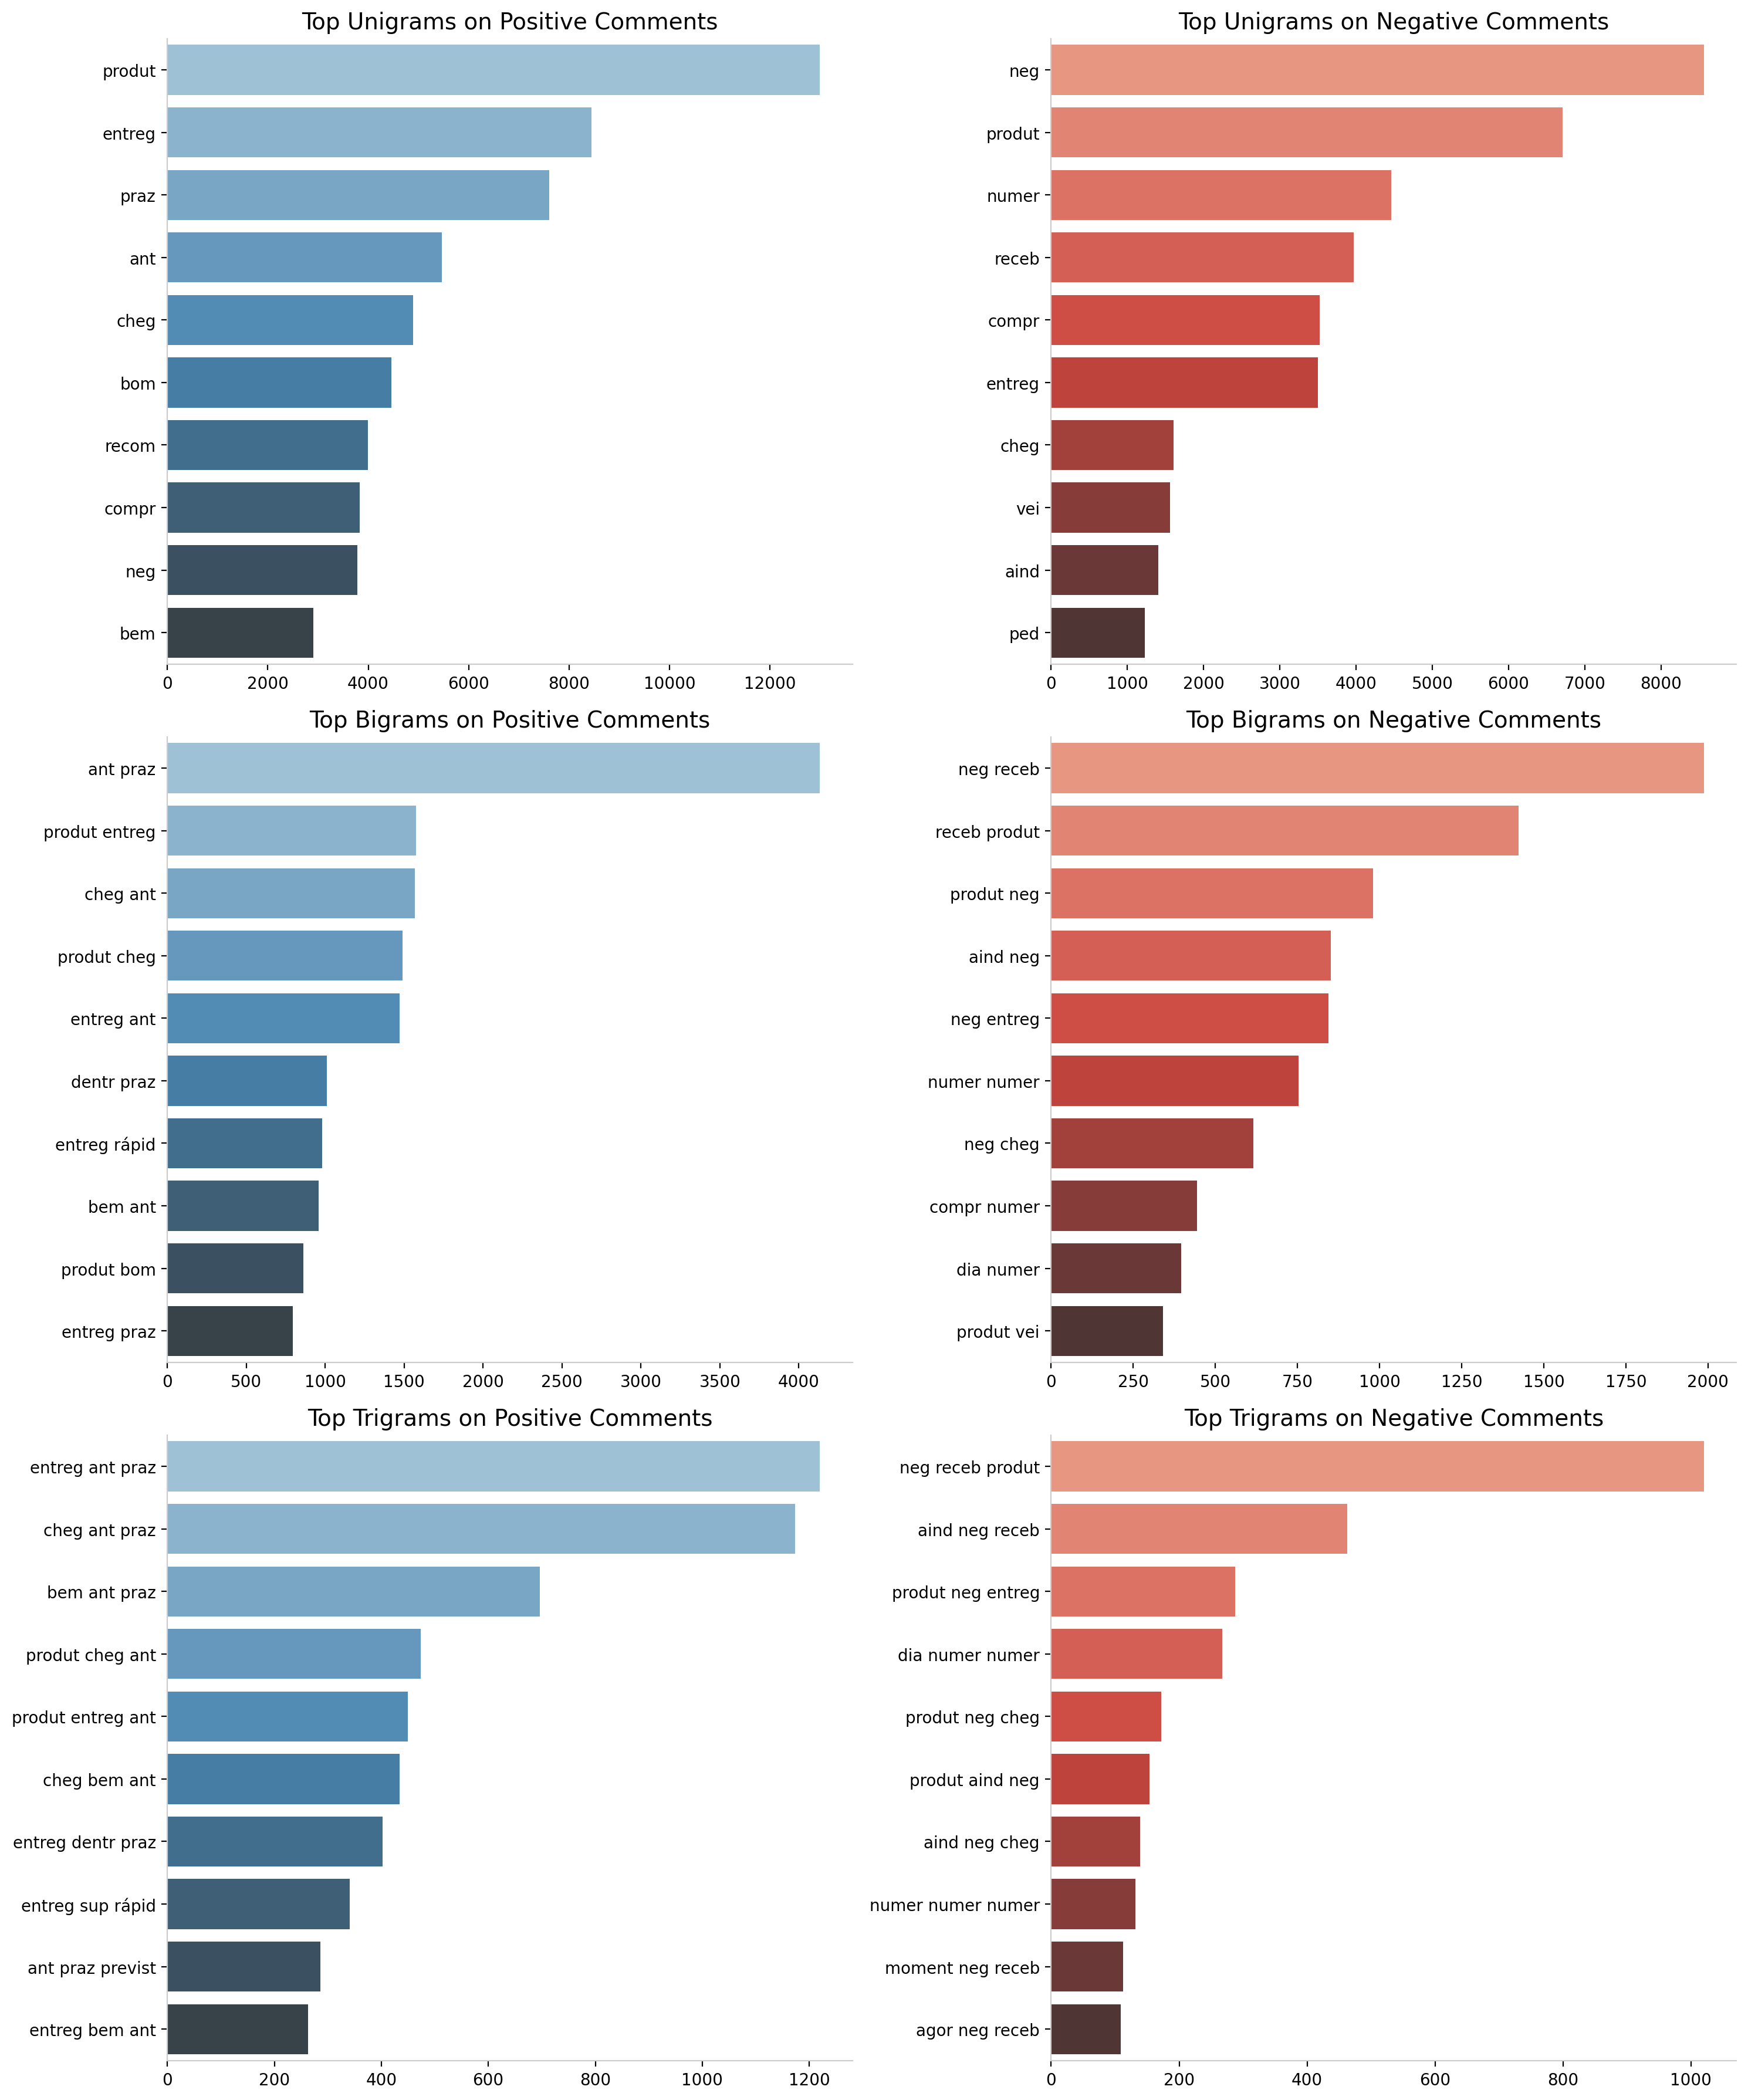

In [53]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

The barcharts above are interesting and they really reflect the sentiment based on ngrams. We can clearly see negative words on bigrams and trigrams by the right side of the figure (the most frequent trigram `neg receb produt` in english means  `didn't receive the product` for example).

The positive bigrams and trigrams at the blue left side of the figure really consists of positive words (the most frequent trigram `entreg ant praz` means `delivery before time` in english). Also!

## Pipeline

So, after detailing all the steps considered on this text prep pipeline, let's build a code to apply a complete pipeline automatically to handle it. This is a important step on the project because with this we can receive a text input and apply all changes on it to make it ready for training or predicting the sentiment label.

In [54]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [55]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

Just to remember, in the pipeline above we chose the TF-IDF approach to extract features from text using the same parameters we used on the examples (`max_features=300`, `min_df=7`, `max_df=0.8`). It means that every text string in our corpus will be 300 "text features" respecting the criteria defined by the min_df and max_df parameters. Let's apply it.

In [56]:
# Defining X and y 
idx_reviews = order_reviews['review_comment_message'].dropna().index
score = order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


# Sentiment Classification

This is the final step! After all the text preparation we've done, it's now time to put it together into a classification model to train an algorithm that understands wherever a text string has a `positive` or a `negative` feeling based on the features we extracted from the corpus.

So, let's use a homemade class for make the training and analysis easier.

In [57]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

___
* _Training selected Machine Learning models_
___

In [58]:
# Creating an object and training the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


___
* _Evaluating models_
___

In [59]:
clf_tool.classifiers_info

{'LogisticRegression': {'estimator': LogisticRegression(C=np.float64(3.747368421052632), random_state=42,
                     solver='liblinear')},
 'Naive Bayes': {'estimator': GaussianNB()}}

In [60]:
y_train

array([1, 1, 1, ..., 1, 1, 1], shape=(32781,))

In [61]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

Evaluating model LogisticRegression

Evaluating model Naive Bayes



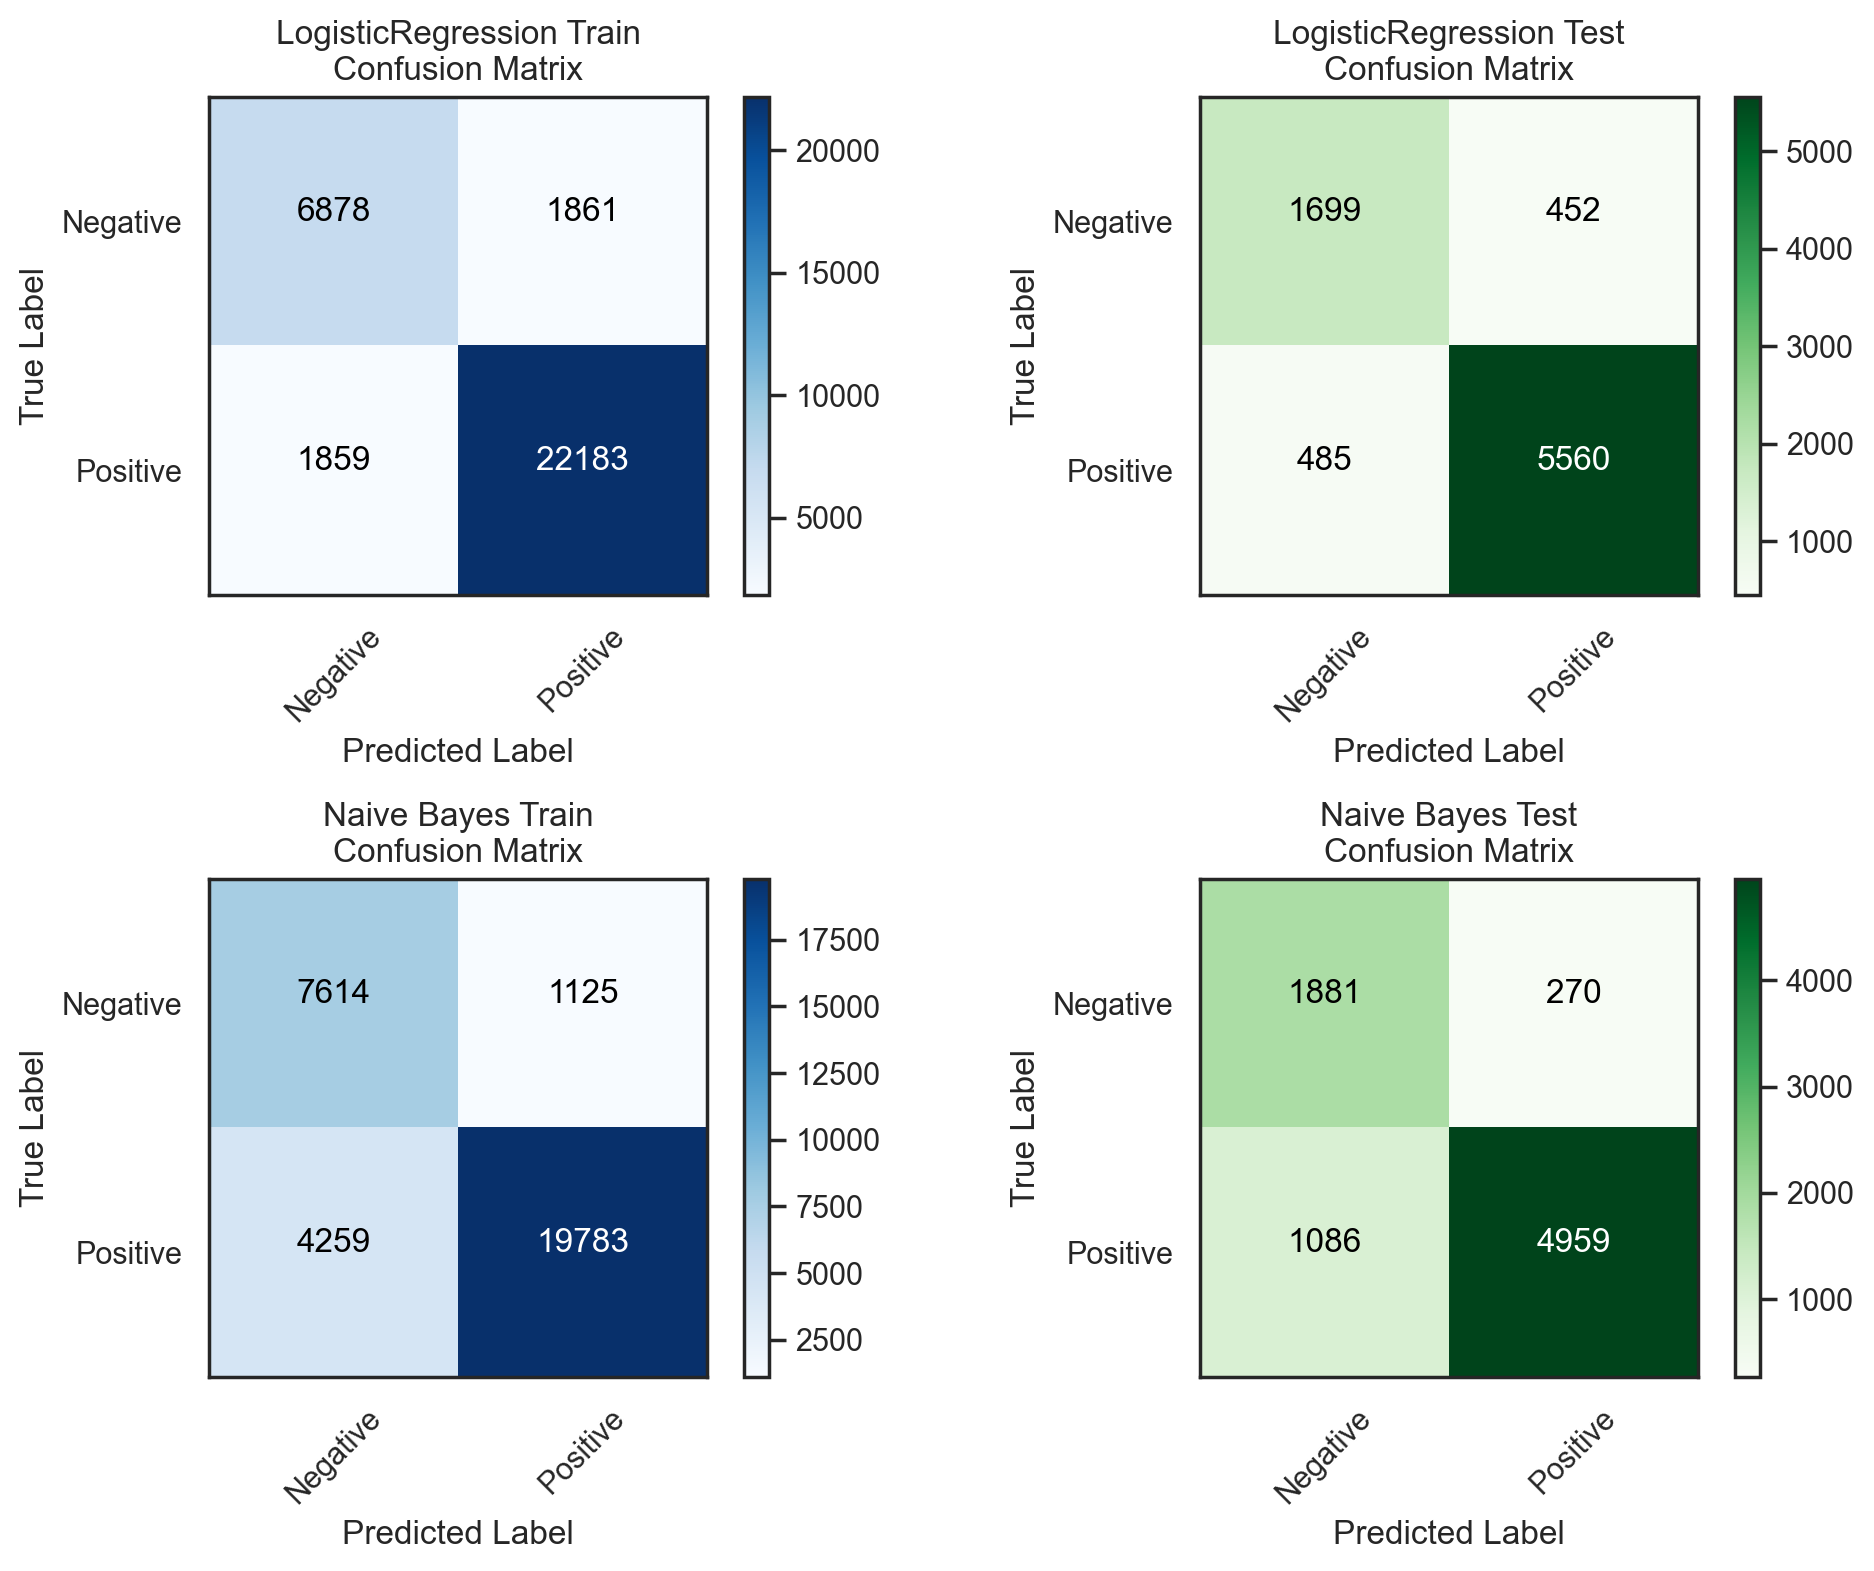

In [62]:
clf_tool.plot_confusion_matrix(classes=['Negative', 'Positive'])

- The best model was logistic regression, with an f1 test score of 92%. 
- As we can see in the confusion matrix, the predictions are evenly distributed (same positive/negative ratio as the true label).

## Final Implementation

Finally we can build up our final step to delivery a Sentiment Analysis model! We have a full prep pipeline, a machine learning model (to choose) and now the only thing we can do to improve it is to build a connected solution that can receive a input text string (say an e-commerce comment) and return its sentiment. Let's try!

In [111]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [112]:
# Defining transformers for preparing the text input
model = clf_tool.classifiers_info['LogisticRegression']['estimator']
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

Now let's try to write a phrase to feed our `sentiment_analysis` function. In production, we can adapt it to serve any application. So, let's simulate an online review that says something like `Very bad product! I don't buy on this store anymore, the delivery was late and it cost so much money`.

What's the sentiment of this given phrase?

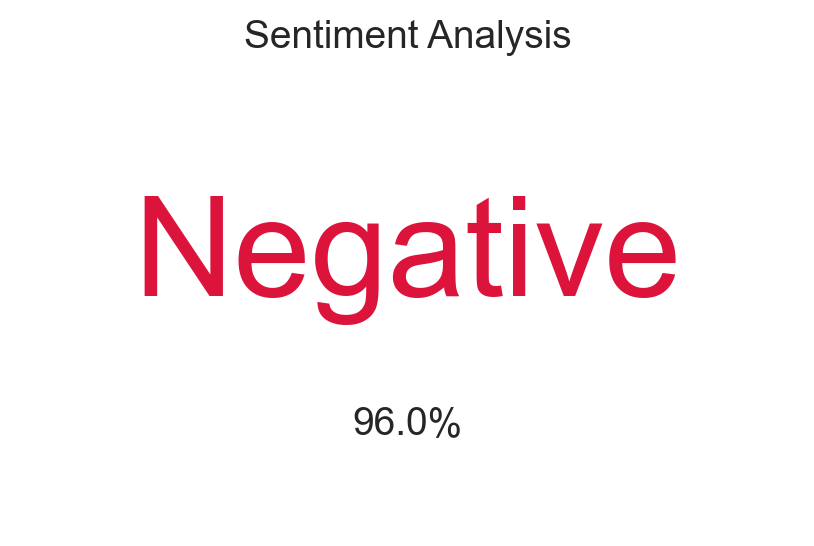

In [118]:
comment = 'Produto péssimo! Não compro mais nesta loja, a entrega atrasou e custou muito caro..'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

Excelent! Our model returned exactly we expected. Now, let' simulate a comment that says something like `I love it and it really fulfilled the expectations. I bought for a cheap value. Wonderful`.

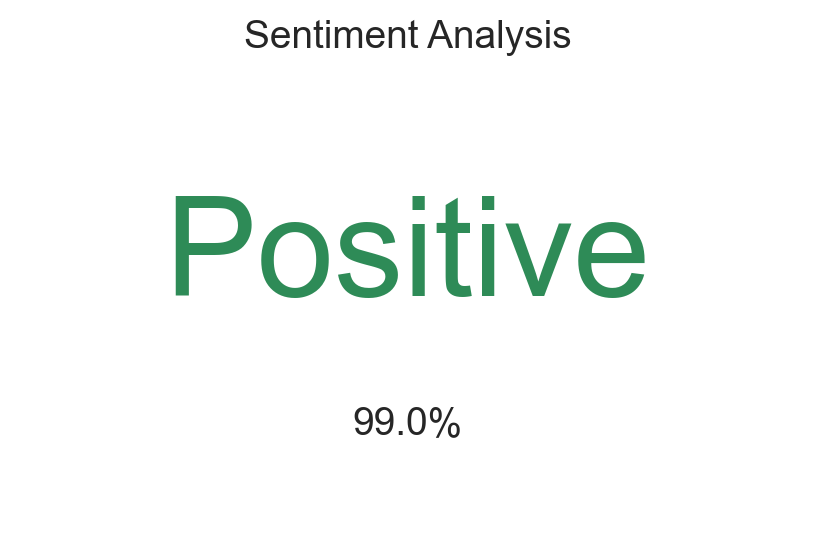

In [114]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

At least, let's try to simulate a very neutral comment. Something like `I don't know if a liked this product. The cost was cheap but it was defectuous. If you're lucky, it worths`

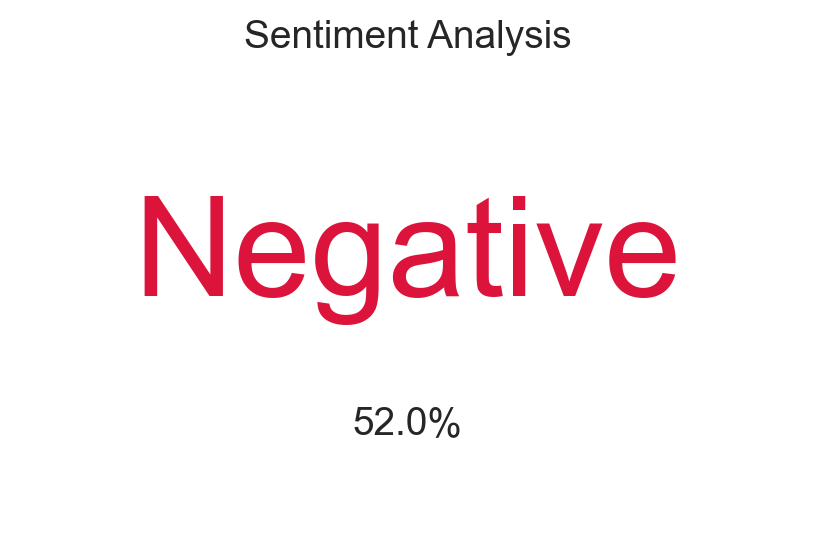

In [119]:
comment = 'Não sei se gostei deste produto. O preço era baixo, mas veio com defeito. Se você tiver sorte, pode valer a pena..'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

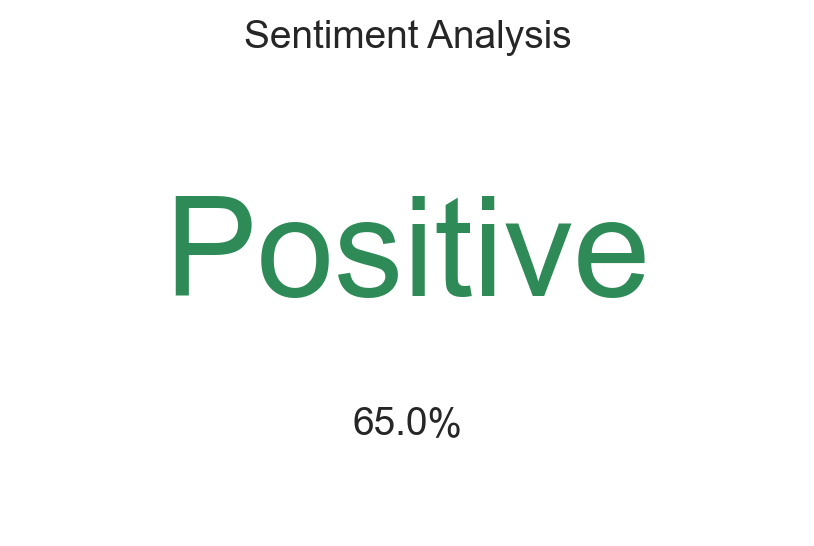

In [121]:
comment = 'Não me serviu bem, o tamanho que pedi era maior do que eu pensava, acho que vou ter que devolver.'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

## Conclusion

Well, in this notebook, we learned how to perform Sentimental Analysis. We inputted the text step by step, from cleaning it up to finally extracting the people's feelings behind that review. We are now able to expand this to a high-level application that automatically detects the sentiment of a given text or phrase.

## Complete Script

Now, by the end of our detailed implementation, I want to share with you how this project could be implemented as complete structure project in production. The script above is exactly the same the one I built in my machine to prepare myself for a real problem.

___
* _Project Transformers_
___

In [72]:
"""
This python script will allocate all the custom transformers that are specific for the project task.
The idea is to encapsulate the classes and functions used on pipelines to make codes cleaner.
"""

# Importing libraries
from sklearn.base import BaseEstimator, TransformerMixin


"""
-----------------------------------
----- 1. CUSTOM TRANSFORMERS ------
           1.1 Classes
-----------------------------------
"""


class ColumnMapping(BaseEstimator, TransformerMixin):
    """
    This class applies the map() function into a DataFrame for transforming a columns given a mapping dictionary

    Parameters
    ----------
    :param old_col_name: name of the columns where mapping will be applied [type: string]
    :param mapping_dict: python dictionary with key/value mapping [type: dict]
    :param new_col_name: name of the new column resulted by mapping [type: string, default: 'target]
    :param drop: flag that guides the dropping of the old_target_name column [type: bool, default: True]

    Returns
    -------
    :return X: pandas DataFrame object after mapping application [type: pd.DataFrame]

    Application
    -----------
    # Transforming a DataFrame column given a mapping dictionary
    mapper = ColumnMapping(old_col_name='col_1', mapping_dict=dictionary, new_col_name='col_2', drop=True)
    df_mapped = mapper.fit_transform(df)
    """

    def __init__(self, old_col_name, mapping_dict, new_col_name='target', drop=True):
        self.old_col_name = old_col_name
        self.mapping_dict = mapping_dict
        self.new_col_name = new_col_name
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Applying mapping
        X[self.new_col_name] = X[self.old_col_name].map(self.mapping_dict)

        # Dropping the old columns (if applicable)
        if self.drop:
            X.drop(self.old_col_name, axis=1, inplace=True)

        return X

___
* _Complete Python Script for Training a Sentiment Classifier_
___

The code below is end-to-end solution for creating a sentiment classification model using the olist e-commerce reviews dataset. As I said before, this script was built on my personal machine, so I commented the lines of code that saves something on the fileserver.

In [73]:
os.path.dirname(os.getcwd())

'e:\\Danie\\Documents\\Programacion\\Brazilian-E-commerce'

In [74]:
"""
--- SUMMARY ---

1. Project Variables
2. Reading Data
3. Prep Pipelines
    3.1 Initial Preparation
    3.2 Text Transformers
4. Modeling
    4.1 Model Training
    4.2 Evaluating Metrics
    4.3 Complete Solution
    4.4 Final Model Performance
    4.5 Saving pkl Files
"""


# Importing libs
import os
import numpy as np
import pandas as pd
#from dev.training.project_transformers import ColumnMapping
from utils.custom_transformers import import_data, DropNullData, DropDuplicates
from utils.text_utils import re_breakline, re_dates, re_hiperlinks, re_money, re_negation, re_numbers, \
    re_special_chars, re_whitespaces, ApplyRegex, StemmingProcess, StopWordsRemoval
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump
from sklearn.linear_model import LogisticRegression
from utils.ml_utils import BinaryClassifiersAnalysis, cross_val_performance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve


"""
-----------------------------------
------ 1. PROJECT VARIABLES -------
-----------------------------------
"""

# Variables for address paths
# Jupyter Notebook not work with __file__ variable, then we use os.getcwd()
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = f'{BASE_DIR}/data' 
PIPELINES_PATH = '../pipelines' 
MODELS_PATH = '../models' 

# Variables for reading the data
FILENAME = 'olist_order_reviews_dataset.csv'
COLS_READ = ['review_comment_message', 'review_score']
CORPUS_COL = 'review_comment_message'
TARGET_COL = 'target'

# Defining stopwords
PT_STOPWORDS = stopwords.words('portuguese')

# Variables for saving data
METRICS_FILEPATH = 'metrics/model_performance.csv'

# Variables for retrieving model
MODEL_KEY = 'LogisticRegression'


"""
-----------------------------------
-------- 2. READING DATA ----------
-----------------------------------
"""

# Reading the data with text corpus and score
df = import_data(os.path.join(DATA_PATH, FILENAME), usecols=COLS_READ)


"""
-----------------------------------
------- 3. PREP PIPELINES ---------
    3.1 Initial Preparation
-----------------------------------
"""

# Creating a dictionary for mapping the target column based on review score
score_map = {
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

# Creating a pipeline for the initial prep on the data
initial_prep_pipeline = Pipeline([
    ('mapper', ColumnMapping(old_col_name='review_score', mapping_dict=score_map, new_col_name=TARGET_COL)),
    ('null_dropper', DropNullData()),
    ('dup_dropper', DropDuplicates())
])

# Applying initial prep pipeline
df_prep = initial_prep_pipeline.fit_transform(df)


"""
-----------------------------------
------- 3. PREP PIPELINES ---------
      3.2 Text Transformers
-----------------------------------
"""

# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Building a text prep pipeline
text_prep_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(PT_STOPWORDS)),
    ('stemming', StemmingProcess(RSLPStemmer())),
    # min y max_df Control which words got deleted according to its frequency on corpus before building matrix TF-IDF
    # min Elimina palabras demasiado raras, ruido, faltas, en este caso que aparezcan en menos de 7 textos
    # max Elimina palabras demasiado comunes, en este caso, que aparezcan en mas del 80% de los textos
    ('vectorizer', TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=PT_STOPWORDS))
])

# Applying the pipeline
X = df_prep[CORPUS_COL].tolist()
y = df_prep[TARGET_COL]
X_prep = text_prep_pipeline.fit_transform(X)

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=.20, random_state=42)

# Saving states before prep pipeline
"""df_prep[CORPUS_COL].to_csv(os.path.join(DATA_PATH, 'X_data.csv'), index=False)
df_prep[TARGET_COL].to_csv(os.path.join(DATA_PATH, 'y_data.csv'), index=False)"""


"""
-----------------------------------
--------- 4. MODELING  -----------
       4.1 Model Training
-----------------------------------
"""

# Specifing a Logistic Regression model for sentiment classification
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    }
}

# Creating an object and training the classifiers
trainer = BinaryClassifiersAnalysis()
trainer.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.2 Evaluating Metrics
-----------------------------------
"""

# Evaluating metrics
performance = trainer.evaluate_performance(X_train, y_train, X_test, y_test, cv=5, save=False,
                                           performances_filepath=METRICS_FILEPATH) # In your project env, save=True and overwrite=True may be useful


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.3. Complete Solution
-----------------------------------
"""

# Returning the model to be saved
model2 = trainer.classifiers_info[MODEL_KEY]['estimator']

# Creating a complete pipeline for prep and predict
e2e_pipeline = Pipeline([
    ('text_prep', text_prep_pipeline),
    ('model', model2)
])

# Defining a param grid for searching best pipelines options (reduced options for making the search faster)
"""param_grid = [{
    'text_prep__vectorizer__max_features': np.arange(500, 851, 50),
    'text_prep__vectorizer__min_df': [7, 9, 12, 15, 30],
    'text_prep__vectorizer__max_df': [.4, .5, .6, .7]
}]"""

param_grid = [{
    'text_prep__vectorizer__max_features': np.arange(500, 501, 50),
    'text_prep__vectorizer__min_df': [7],
    'text_prep__vectorizer__max_df': [.4]
}]

# Searching for best options
grid_search_prep = GridSearchCV(e2e_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_prep.fit(X, y)
print('Best params after a complete search:')
print(grid_search_prep.best_params_)

# Returning the best options
vectorizer_max_features = grid_search_prep.best_params_['text_prep__vectorizer__max_features']
vectorizer_min_df = grid_search_prep.best_params_['text_prep__vectorizer__min_df']
vectorizer_max_df = grid_search_prep.best_params_['text_prep__vectorizer__max_df']

# Updating the e2e pipeline with the best options found on search
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].max_features = vectorizer_max_features
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].min_df = vectorizer_min_df
e2e_pipeline.named_steps['text_prep'].named_steps['vectorizer'].max_df = vectorizer_max_df

# Fitting the model again
e2e_pipeline.fit(X, y)


"""
-----------------------------------
--------- 4. MODELING  -----------
    4.4 Final Model Performance
-----------------------------------
"""

# Retrieving performance for te final model after hyperparam updating
final_model = e2e_pipeline.named_steps['model']
final_p = cross_val_performance(final_model, X_prep, y, cv=5)
#final_performance = final_performance.append(performance)
final_performance = pd.concat([performance,final_p])

print(final_performance)
#final_performance.to_csv(METRICS_FILEPATH, index=False)


"""
-----------------------------------
--------- 4. MODELING  -----------
      4.5 Saving pkl files
-----------------------------------
"""

"""# Creating folders for saving pkl files (if not exists)
if not os.path.exists('../../models'):
    os.makedirs('../../models')
if not os.path.exists('../../pipelines'):
    os.makedirs('../../pipelines')

# Saving pkl files
dump(initial_prep_pipeline, os.path.join(PIPELINES_PATH, 'initial_prep_pipeline.pkl'))
dump(text_prep_pipeline, os.path.join(PIPELINES_PATH, 'text_prep_pipeline.pkl'))
dump(e2e_pipeline, os.path.join(PIPELINES_PATH, 'e2e_pipeline.pkl'))
dump(final_model, os.path.join(MODELS_PATH, 'sentiment_clf_model.pkl'))"""

This dataset has 2 columns, which 1 is/are applicable to optimization.

----------------------------------------------------
Memory usage (50 lines): 0.0009 MB
Memory usage after optimization (50 lines): 0.0007 MB
----------------------------------------------------

Reduction of 21.46% on memory usage

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Evaluating model LogisticRegression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params after a complete search:
{'text_prep__vectorizer__max_df': 0.4, 'text_prep__vectorizer__max_features': np.int64(500), 'text_prep__vectorizer__min_df': 7}
                model          approach     acc  precision  recall      f1  \
0  LogisticRegression  Treino 5 K-folds  0.8809     0.9053  0.9025  0.9039   
0  LogisticRegression             Teste  0.8796     0.8999  0.9053  0.9026   
0  LogisticRegression       Final Model  0.8809     0.9051  0.9024  0.9037   

      auc  total_time an

"# Creating folders for saving pkl files (if not exists)\nif not os.path.exists('../../models'):\n    os.makedirs('../../models')\nif not os.path.exists('../../pipelines'):\n    os.makedirs('../../pipelines')\n\n# Saving pkl files\ndump(initial_prep_pipeline, os.path.join(PIPELINES_PATH, 'initial_prep_pipeline.pkl'))\ndump(text_prep_pipeline, os.path.join(PIPELINES_PATH, 'text_prep_pipeline.pkl'))\ndump(e2e_pipeline, os.path.join(PIPELINES_PATH, 'e2e_pipeline.pkl'))\ndump(final_model, os.path.join(MODELS_PATH, 'sentiment_clf_model.pkl'))"

In [75]:
text_prep2 = e2e_pipeline.named_steps['text_prep']
clean_text2 = text_prep2.transform(['Eu não gostei.'])
clean_text2

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 500)>

In [76]:
model3 = e2e_pipeline.named_steps['model']
model3.predict(clean_text2)

array([0])

In [77]:
# save the model as a pkl file
with open('sentiment-analysis-pipeline-0.1.0.pkl', 'wb') as f:
    pickle.dump(e2e_pipeline, f)

In [78]:
df_prep[CORPUS_COL]

3                    Recebi bem antes do prazo estipulado.
4        Parabéns lojas lannister adorei comprar pela I...
9        aparelho eficiente. no site a marca do aparelh...
12         Mas um pouco ,travando...pelo valor ta Boa.\r\n
15       Vendedor confiável, produto ok e entrega antes...
                               ...                        
99205    para este produto recebi de acordo com a compr...
99208    Entregou dentro do prazo. O produto chegou em ...
99215    O produto não foi enviado com NF, não existe v...
99221    Excelente mochila, entrega super rápida. Super...
99223    meu produto chegou e ja tenho que devolver, po...
Name: review_comment_message, Length: 36348, dtype: object

In [79]:
X_1 = pd.Series(['O produto me serviu bem.',
                'O tamanho estava correto.'], index=[0, 1])
X_1.to_csv('X_data_sample3.csv', index=False)

In [80]:
x = pd.read_csv('X_data_sample3.csv')
x

0
0   O produto me serviu bem.
1  O tamanho estava correto.

In [81]:
final_p

anomesdia         anomesdia_datetime               model     approach  \
0  20251211 2025-12-11 14:18:11.164762  LogisticRegression  Final Model   

      acc  precision  recall      f1     auc  total_time  
0  0.8809     0.9051  0.9024  0.9037  0.9379       1.256

In [82]:
final_performance

model          approach     acc  precision  recall      f1  \
0  LogisticRegression  Treino 5 K-folds  0.8809     0.9053  0.9025  0.9039   
0  LogisticRegression             Teste  0.8796     0.8999  0.9053  0.9026   
0  LogisticRegression       Final Model  0.8809     0.9051  0.9024  0.9037   

      auc  total_time anomesdia         anomesdia_datetime  
0  0.9374       0.994       NaN                        NaT  
0  0.9384       0.009       NaN                        NaT  
0  0.9379       1.256  20251211 2025-12-11 14:18:11.164762

In [83]:
np.linspace(0.1, 10, 20)

array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])

In [84]:
performance

model          approach     acc  precision  recall      f1  \
0  LogisticRegression  Treino 5 K-folds  0.8809     0.9053  0.9025  0.9039   
0  LogisticRegression             Teste  0.8796     0.8999  0.9053  0.9026   

      auc  total_time  
0  0.9374       0.994  
0  0.9384       0.009

In [85]:
type(X_prep)

scipy.sparse._csr.csr_matrix

In [86]:
y_df = pd.DataFrame(y)
y_series = pd.Series(y_df['target'].values)
len(y_series)

36348

In [87]:
from scipy.sparse import save_npz
from scipy.sparse import load_npz

save_npz('./X_prep.npz', X_prep)

In [88]:
X_load = load_npz('X_prep.npz')

In [89]:
X_load

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 215345 stored elements and shape (36348, 300)>

In [90]:
X_prep

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 215345 stored elements and shape (36348, 300)>

In [91]:
df_prep

review_comment_message  target
3                  Recebi bem antes do prazo estipulado.       1
4      Parabéns lojas lannister adorei comprar pela I...       1
9      aparelho eficiente. no site a marca do aparelh...       1
12       Mas um pouco ,travando...pelo valor ta Boa.\r\n       1
15     Vendedor confiável, produto ok e entrega antes...       1
...                                                  ...     ...
99205  para este produto recebi de acordo com a compr...       1
99208  Entregou dentro do prazo. O produto chegou em ...       1
99215  O produto não foi enviado com NF, não existe v...       0
99221  Excelente mochila, entrega super rápida. Super...       1
99223  meu produto chegou e ja tenho que devolver, po...       0

[36348 rows x 2 columns]